#### Model taken from:
- Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- Modelling and Control of Offshore Marine Pipeline during Pipelay. Gullik A. Jensen et al

M(q)q ̈ + C(q,q ̇)q ̇ + H(q,q ̇)q ̇ + f(q) + g(q) = τ

In [1]:
# DONE - make sure all parameters (vessel and pipe) are in the same reference frame, e.g p.78, p.142
# DONE - do I have seabed interaction force in the model?
# DONE - applied top tension in dynamic case might have been time varying, Jensen thesis p.76-77
# DONE - do I have stinger accounted in the model? do I need stinger in the model?, see 3338.pdf
# DONE - degree - radians
# DONE - verify results against the catenary
# DONE - add more nodes

# TODO - roller reaction (force) should be proportional to pipe vertical displacement at rollers?

# TAKEAWAY - use catenary for initial input

In [2]:
import numpy as np
import math
from scipy.integrate import odeint, ode, solve_ivp
from scipy.integrate import ode
from scipy.misc import derivative
from numpy.linalg import inv, pinv
import numdifftools as nd
import tqdm
import functools
from datetime import datetime
from scipy.optimize import fsolve

In [3]:
%matplotlib inline

In [4]:
import matplotlib.pyplot as plt

### Inputs

In [5]:
pipe_joint_length = 2763 #250 #600 #100 # [m]
pipe_weight_per_unit_length = 96 #  (submerged) [kg/m]  # 113.07 - not submerged

q = [0.9939840275055615, 1.986772044151028, 1.9831911966919273, 1.9772469629333669] # used for initial checks only but not in final solution 
l = [pipe_joint_length for i in range(len(q))]

# mn = 5.08976 * 10e7 # mass of the vessel, [kg]
# In = 5.041*10e7 # moment of inertia of the vessel, [kg*𝑚2]
# mn = 80048 # mass of the vessel, [kg]
# In = 50410 # moment of inertia of the vessel, [kg*𝑚2]

mn = 32219000 # mass of the vessel, [kg]
# mn = 5.08976 *1e7 # mass of the vessel, [kg]

In [6]:
# L - the hull length
# Xg - x-center of gravity

L = 169 # [m]
Xg = 78 # [m]
# L = 240 # [m]
# Xg = 120 # [m]

In [7]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [8]:
In = vessel_inertia_moment(mn,Xg,L)

In [9]:
In

253533324687.5

In [10]:
mi = [x*pipe_weight_per_unit_length for x in l] # mass of pipe element (submerged), [kg]

In [11]:
# for hydrodynamic damping matrix
Cd=[0.87, 0.87, 0.87, 1.6] # Drag coefficient
# Cd=0.82 # Drag coefficient

qw = 1025 # Water density [kg/m3]
d0 = 0.7610 # Outer diameter of pipe, [m]
dI= 0.69# Inner diameter of pipe, [m]

In [12]:
# for vector of spring forces in the pipe joints
# K = 1.4*10e11
E = 210e9 # modulus of elasticity of steel, [N/m^2]
EI = E*3.14/64*(d0**4-dI**4) # Bending stiffness [N*m^2]

K = EI#10e7 # depends on the unit bending stiffness of the pipe (EI), 
       # and the length li, of the link; from the Jensen thesis [N/m]

In [13]:
K

1120051921.710554

In [14]:
# for vector of control inputs
tau_qn = 250576 # tension in pipe at water level, [N] (check Jee sheets)
Fx_ = 1.4e+08 #7.5e7 # 5e7 # [N], from the Jensen thesis
# Fy=-100*1000 # [N],

In [15]:
# for solution
max_t = 600  
dt = 0.5
t=np.arange(0,max_t,dt)
# q0=[45, 0, 20, 0, 15, 0, 5, 0]

In [16]:
Awp = 1000 # the waterplane area of the vessel, [m^2]
# h=26.3 # water depth, [m]
h=700

# fip=1e10
fip=1e12

In [17]:
kp=1.95e4
# T = 200 # Measure the period of oscillation, from experiments
# kd=0.075*kp*T 
kd=1.5e4
# kd=0.5e8 # change 

### System inertia matrix 

In [18]:
def alpha(q):
    sum_=0
    ans=[]
    for i in range(len(q)):
        sum_+=q[i]
        ans.append(sum_)
    return np.array(ans)

In [19]:
def Jv(q, i, l):
    alp=alpha(q)
    def Jv0(i, k, alp, l):
        
        if k<i:
            tmp1=np.dot(np.array(l[k:i]),np.sin(np.radians(alp[k:i])))
            tmp1=-tmp1-0.5*l[i]*np.sin(np.radians(alp[i]))
            
            tmp2 =np.dot(np.array(l[k:i]),np.cos(np.radians(alp[k:i])))
            tmp2=tmp2+0.5*l[i]*np.cos(np.radians(alp[i]))
                        
            return np.array([tmp1, tmp2]).T
        elif k==i:
            return np.array([-0.5*l[i]*np.sin(np.radians(alp[i])),
                    0.5*l[i]*np.cos(np.radians(alp[i]))]).T
        else:
            return np.array([0, 0]).T                 
    
    ans=np.array([Jv0(i, k, alp, l) for k in range(len(q))])
    
    return ans.T

In [20]:
Jv(q, 2, l)

array([[-311.14808342, -263.21715145, -119.53964925,    0.        ],
       [6898.16451361, 4135.58028398, 1376.31846687,    0.        ]])

In [21]:
def Jomega(i,q):

    def Jomega0(i,k):
        if k<=i:
            return 1
        return 0
    ans=np.array([Jomega0(i, k) for k in range(len(q))])
   
    return ans.reshape(len(q),1).T

In [22]:
def M(q, l, mn, In, mi):
  
    
    sum1 = mn * np.dot(Jv( q, len(q)-1, l).T, Jv(q, len(q)-1, l))
    
 
    sum2 = In * np.dot(Jomega(len(q)-1,q).T, Jomega(len(q)-1,q))
    
    sum3=0
    
    for i in range(len(q)-1):
        J_v = Jv(q, i, l)
        sum3+=mi[i]*np.dot(J_v.T, J_v)
      
    return sum1 + sum2 + sum3   

In [23]:
In

253533324687.5

In [24]:
M(q, l, mn, In, mi)

array([[3.02720849e+15, 2.15912818e+15, 1.29225988e+15, 4.29663965e+14],
       [2.15912818e+15, 1.54156929e+15, 9.23554020e+14, 3.07343239e+14],
       [1.29225988e+15, 9.23554020e+14, 5.54035229e+14, 1.84654279e+14],
       [4.29663965e+14, 3.07343239e+14, 1.84654279e+14, 6.17448561e+13]])

### Coriolis-centripetal matrix

In [25]:
# TODO - not sure about this formula 
def C(q, dq, l, mn, In, mi): #here
    ans = np.zeros((len(q),len(q)))              
    fun = lambda q: M(q, l, mn, In, mi)
    Dfun = nd.Gradient(fun) 
    
    dq1_, dq2_, dq3_, dq4_ = Dfun(q)
    diff = np.array([dq1_, dq2_, dq3_, dq4_])
    
    def c(i,j,k):
        return 0.5 *(diff[k].item((i,j))+
                     diff[j].item((i,k))-
                     diff[i].item((j,k)))
    
    for i in range(len(q)):
        for j in range(len(q)):
            for k in range(len(q)):
                ans[i][j]+=c(i,j,k)*np.radians(dq[k])
    return ans                  

In [26]:
dq=[1,1,0.5,1]

In [27]:
C(q, dq, l, mn, In, mi)

array([[ 5.35255986e-03,  2.17932494e+10,  3.08223034e+10,
         1.97267543e+10],
       [-4.35864987e+10, -5.85996236e+09,  8.42838240e+09,
         9.05239594e+09],
       [-6.16446067e+10, -3.04921838e+10, -9.73615886e+09,
        -6.50570818e+08],
       [-3.94535087e+10, -2.39271692e+10, -1.22836091e+10,
        -6.14395000e+09]])

### Hydrodynamic damping matrix

In [28]:
def R_I_Bi(i, alp):
    return np.array([[np.cos(np.radians(alp[i])), -np.sin(np.radians(alp[i]))],
                    [np.sin(np.radians(alp[i])), np.cos(np.radians(alp[i]))]])

In [29]:
alp=alpha(q)

In [30]:
R_I_Bi(2, alp)

array([[ 0.99624934, -0.08652888],
       [ 0.08652888,  0.99624934]])

In [31]:
I_=np.array([[0,0],
             [0,1]])

In [32]:
def Pi(i,alp):
    return np.dot(np.dot(R_I_Bi(i, alp),I_),R_I_Bi(i, alp).T)

In [33]:
# TODO - not sure about this formula 
def mod_Vn(q, alp, dq):
    ans=[]
    for j in range(len(q)):
        ans.append(np.dot(np.dot(Pi(j,alp),Jv( q,j, l)), np.radians(dq)))
    return np.linalg.norm(np.array(ans))

In [34]:
mod_Vn(q,alp,dq)

416.7166853577408

In [35]:
# TODO - not sure about this formula 
def mod_Vni(i,q,alp,dq):
    return np.linalg.norm(np.dot(np.dot(Pi(i,alp),Jv( q,i, l)), np.radians(dq)))

In [36]:
mod_Vni(len(q)-1,q,alp,dq)

349.0583462872576

In [37]:
def gamma(i):
    return 0.5*Cd[i]*qw*d0*l[i]

In [38]:
def H(alp,q,dq,l):
    ans=np.zeros((len(q), len(q)))
    alp=alpha(q)
    for j in range(len(q)):
        ans+=gamma(j)*mod_Vni(j,q,alp,dq)*np.dot(np.dot(Jv(q,j,l).T,Pi(j,alp)),Jv( q,j, l))
    return ans    

In [39]:
print(alp)
print(q)

[0.99398403 2.98075607 4.96394727 6.94119423]
[0.9939840275055615, 1.986772044151028, 1.9831911966919273, 1.9772469629333669]


In [40]:
H(alp,q,[0,0,0,0.1],l)

array([[3.86925132e+14, 2.76706657e+14, 1.66156380e+14, 5.54074527e+13],
       [2.76706657e+14, 1.97884726e+14, 1.18825510e+14, 3.96242315e+13],
       [1.66156380e+14, 1.18825510e+14, 7.13521564e+13, 2.37934964e+13],
       [5.54074527e+13, 3.96242315e+13, 2.37934964e+13, 7.93431484e+12]])

### Vector of spring forces in the pipe joints

In [41]:
def f(q,k):
    ans=np.array([k*q[i] for i in range(len(q))])
    return ans.reshape(len(q),1)

### Vector of gravitational/buoyancy forces

In [42]:
q

[0.9939840275055615, 1.986772044151028, 1.9831911966919273, 1.9772469629333669]

In [43]:
def x(alp,i,l):
    tmp1=np.dot(np.array(l[:i]),np.cos(np.radians(alp[:i])))

    tmp1+=0.5*l[i]*np.cos(np.radians(alp[i]))
    return tmp1

In [44]:
x(alp,2,l)

6898.164513606359

In [45]:
def y(alp,i,l):
    tmp1=np.dot(np.array(l[:i]),np.sin(np.radians(alp[:i])))
#     print(l,alp[i],alp)
#     print(math.sin(math.radians(alp[i])))
    tmp1+=0.5*l[i]*np.sin(np.radians(alp[i]))
    return tmp1

In [46]:
y(alp,2,l)

311.1480834242025

In [47]:
G=np.array([0,-9.81]).T

def ggi(i,G):
    return mi[i]*G
   
    
def gbi(G,l,i):
    return -3.14*l[i]*(d0**2/4)*qw*G 

# not complete formula
def gt(alp,fip, i): 
    return -fip*np.radians(alp[i])


In [48]:
# TODO understand the commeted part and incorporate it in model 
def g(q,alp):
    sum_=0
    for i in range(len(q)-1):
        sum_+=np.dot(Jv( q,i, l).T,ggi(i,G)+gbi(G,l,i))
#     print(-qw)   
#     print(Awp)
#     print(y(alp,len(alp)-1,l))
#     print(h)
#     print(-qw,Awp,y(alp,len(q)-1,l),h)
    tmp = -qw*Awp*(y(alp,len(alp)-1,l)-h)*G 
    sum_ += np.dot(Jv(q,len(q)-1, l).T, tmp)  #- \
#         np.dot(Jomega(len(q)-1).T, gt(q, fip, len(q)-1)).reshape(len(q),) 
    return sum_.reshape(len(q),1)   

In [49]:
g(q,alp)

array([[-9.80321218e+12],
       [-7.02914462e+12],
       [-4.23074288e+12],
       [-1.41145604e+12]])

### Vector of control inputs

In [50]:
# Assume that the stinger is shorter than the link length li for any link i
def tau_q(q,tau_qn): 
    ans= np.array([0 for i in range(len(q))]).reshape(len(q),1)
    ans[-1] = tau_qn
    return ans
# tau_q - control forces from the stinger 

In [51]:
def Fx(q,alp,dq,kp, kd, x_ref = 0):
#     print(-kp*(x(q,len(q)-1,l)-x_ref))
#     return -kp*(x(q,len(q)-1,l)-x_ref) - kd*np.dot(np.dot(Pi(len(q)-1,q),Jv( q, len(q)-1, l)), np.radians(dq)) 
    return -kp*(x(alp,len(q)-1,l)-x_ref) - kd*mod_Vn(q,alp,dq)

In [52]:
Fx(q,alp,dq,kp, kd, x_ref = 0)

-194344972.8231884

In [53]:
F1=np.array([Fx_,0]).reshape(2,1) # actuates the vessel in the surge direction in frame Bn
# F=np.array([0,Fy]).reshape(2,1)
def tau_t(q, F):
#     print(Jv(q,len(q)-1, l).T)
    tmp= np.dot(Jv(q,len(q)-1, l).T, F)
    return tmp
#     ans=np.zeros((len(q),1))
#     ans[-1][0]=tmp[-1][0]
#     return  ans # the thruster forces

In [54]:
tau_t(q, F1)

array([[-8.36699924e+10],
       [-7.69596619e+10],
       [-5.68448116e+10],
       [-2.33737098e+10]])

In [55]:
tau_q_wave=9e6 # (taken from article on forces to semi-submersible platform),[N]
# this function purly my invention
# TODO - for improvement see Jensen thesis p. 49
def tau_wave(q,alp, tau_q_wave):
    Y0=y(alp,0,l)
    C=np.exp(y(alp,len(q)-1,l))-np.exp(y(alp,0,l))
    ans=[]
    for i in range(len(q)):
        ans.append([tau_q_wave/C*(np.exp(y(alp,i,l))-np.exp(y(alp,0,l)))])   
    return np.array(ans)

In [56]:
tau_wave(q,alp, tau_q_wave)

array([[0.00000000e+000],
       [2.60965835e-201],
       [3.39755801e-118],
       [9.00000000e+006]])

In [57]:
def tau(q, alp, tau_qn, F, tau_q_wave):
#     return tau_q(q,tau_qn) + tau_t(q, F) + tau_wave(q, tau_q_wave)
#     return tau_t(q, F) + tau_wave(q, tau_q_wave)
#     return  tau_t(q, F)
    return tau_t(q, F) + tau_wave(q, alp, tau_q_wave)

In [58]:
# f1=C*eh1+b
# f2=C*eh2+b

# f1=C*(eh1-eh2)
# f2=f1/(eh1-eh2)eh2+b
# b=

In [59]:
q,alp

([0.9939840275055615,
  1.986772044151028,
  1.9831911966919273,
  1.9772469629333669],
 array([0.99398403, 2.98075607, 4.96394727, 6.94119423]))

In [60]:
tau_wave(q,alp, tau_q_wave)

array([[0.00000000e+000],
       [2.60965835e-201],
       [3.39755801e-118],
       [9.00000000e+006]])

In [61]:
tau(q, alp, tau_qn, F1, tau_q_wave)

array([[-8.36699924e+10],
       [-7.69596619e+10],
       [-5.68448116e+10],
       [-2.33647098e+10]])

### Static solution

In [62]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [63]:
Ws = pipe_weight_per_unit_length*9.81 # [N/m]

In [64]:
# lift_off_slope = 62#30.6 # from Jee catenary sheet, [deg]

In [65]:
# Fx_=250000 # [N]

In [66]:
# horizontal_length =(Fx_/Ws)*math.asinh(np.tan(np.radians(lift_off_slope)))

# below from Jensen thesis 

# Fx_=52347339
# a0=Fx_/(Ws*h)
# a1=math.sqrt(2*a0+1)/a0

# horizontal_length=h*np.log((a1+math.sqrt(a1**2+1))**a1)

In [67]:
# http://abc-moorings.weebly.com/catenary-calculator.html

In [68]:
Fx_0=82945396

In [69]:
S=math.sqrt(h*(2*Fx_0/Ws -h))
horizontal_length=(Fx_0/Ws -h)*np.log((S+Fx_0/Ws)/(Fx_0/Ws-h))

In [70]:
horizontal_length

11052.68484446162

In [71]:
number_of_elements=4

In [72]:
delta_x=horizontal_length/number_of_elements

In [73]:
x0=[i*delta_x for i in range(number_of_elements+1)]
y0=[]
for i in range(len(x0)):
    y0.append(catenary(x0[i],Ws,Fx_))

In [74]:
x0

[0.0,
 2763.171211115405,
 5526.34242223081,
 8289.513633346216,
 11052.68484446162]

In [75]:
q=[]
l_=[]
deg_=[0]

for i in range(len(x0)-1):
    l_.append(np.sqrt((x0[i+1]-x0[i])**2+(y0[i+1]-y0[i])**2))
    deg =np.degrees(math.atan((y0[i+1]-y0[i])/(x0[i+1]-x0[i])))
    q.append(deg-deg_[-1]) 
    deg_.append(deg)


In [76]:
alp_=alpha(q)

In [77]:
q

[0.5324914472404209,
 1.0647989485770295,
 1.0642474284519123,
 1.0633292855171863]

In [78]:
l_

[2763.290547654398, 2764.2453018073493, 2766.1551399557356, 2769.0207218985934]

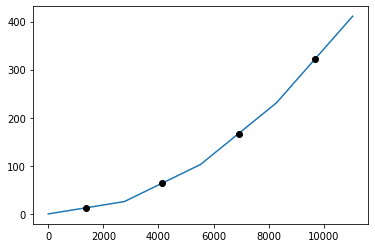

In [79]:
plt.plot(x0, y0)
plt.plot(x(alp_,0,l_),y(alp_,0,l_), 'o', color='black')
plt.plot(x(alp_,1,l_),y(alp_,1,l_), 'o', color='black')
plt.plot(x(alp_,2,l_),y(alp_,2,l_), 'o', color='black')
plt.plot(x(alp_,3,l_),y(alp_,3,l_), 'o', color='black')
plt.show()

In [80]:
q0=[]
for i in range(len(q)):
    q0.append(q[i])
    q0.append(0)

In [81]:
q0

[0.5324914472404209,
 0,
 1.0647989485770295,
 0,
 1.0642474284519123,
 0,
 1.0633292855171863,
 0]

In [82]:
q,dq,kp

([0.5324914472404209,
  1.0647989485770295,
  1.0642474284519123,
  1.0633292855171863],
 [1, 1, 0.5, 1],
 19500.0)

In [83]:
alp_=alpha(q)

In [84]:
F_=np.array([-Fx(q,alp_,dq,kp, 0, x_ref = 0),0]).reshape(2,1)

In [85]:
F_

array([[1.88436459e+08],
       [0.00000000e+00]])

In [86]:
def static_func(q):
    alp=alpha(q)
    ans=  f(q, K) + g(q,alp) - tau(q,alp, tau_qn, F_, 0)
    return ans.reshape((len(q),))

In [87]:
root = fsolve(static_func, np.array(q))

In [88]:
root

array([0.73313185, 2.7956858 , 2.83780397, 1.35186778])

In [89]:
q=list(root)

In [90]:
q0=[]
for i in range(len(q)):
    q0.append(q[i])
    q0.append(0)

In [91]:
alp_=alpha(root)

In [92]:
alp_

array([0.73313185, 3.52881765, 6.36662161, 7.71848939])

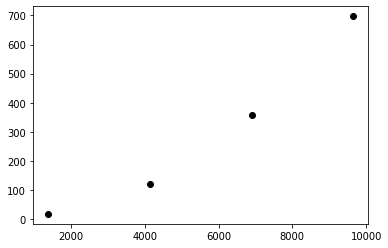

In [93]:
plt.plot(x(alp_,0,l),y(alp_,0,l), 'o', color='black')
plt.plot(x(alp_,1,l),y(alp_,1,l), 'o', color='black')
plt.plot(x(alp_,2,l),y(alp_,2,l), 'o', color='black')
plt.plot(x(alp_,3,l),y(alp_,3,l), 'o', color='black')
plt.show()

In [94]:
q

[0.7331318501868566, 2.7956857962718002, 2.837803967849071, 1.3518677796322582]

In [95]:
q0

[0.7331318501868566,
 0,
 2.7956857962718002,
 0,
 2.837803967849071,
 0,
 1.3518677796322582,
 0]

In [96]:
startTime = datetime.now()

add1=functools.partial(Jv, i=len(q)-1, l=l)
add1__Jv = np.array(list(map(add1, [q])))

add5=functools.partial(f, k=K)
add5__f =np.array(list(map(add5, [q])))

add6=functools.partial(g,alp=alp_)
add6__g =np.array(list(map(add6, [q])))

print(datetime.now() - startTime)

0:00:00.002053


In [97]:
tmp__1=pinv(add1__Jv.transpose(0, 2, 1))
tmp__2= add5__f + add6__g

In [98]:
tmp__=np.matmul(tmp__1, tmp__2)

In [99]:
dim1=int(max_t/dt)
dim2=dim1-1

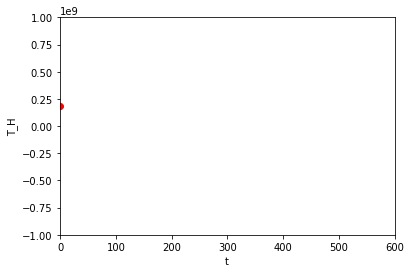

In [100]:
plt.plot(t[:len(tmp__)],tmp__[:,0],'o', color='red')
plt.xlim([-1, dim1//2])
plt.ylim([-1000000000, 1000000000])
plt.xlabel('t')
plt.ylabel('T_H')
plt.show()

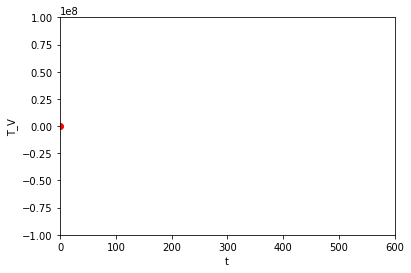

In [101]:
plt.plot(t[:len(tmp__)],tmp__[:,1],'o', color='red')
plt.xlim([-1, dim1//2])
plt.ylim([-100000000, 100000000])
plt.xlabel('t')
plt.ylabel('T_V')
plt.show()

In [102]:
max(tmp__[:,0]), max(tmp__[:,1])

(array([1.88436459e+08]), array([1.12522393e-05]))

### Dynamic solution 

In [103]:
from scipy.linalg import lu_factor, lu_solve

In [104]:
def manipulator(Q, t, q):
    print(t)
    q0,dq0,q1,dq1,q2,dq2,q3,dq3 = Q
    QI=np.array([q0,q1,q2,q3]).reshape(len(q),1)
    dQ=np.array([dq0,dq1,dq2,dq3]).reshape(len(q),1)
    
    QI= QI.flatten().tolist()
    
    alp=alpha(QI)
#     print(alp)
    
#     F0=-Fx(QI,alp,dQ, kp, kd, x_ref = 0)
    
#     if 100<t<120:
#         F=np.array([F0+1e6/120*t, 0]).reshape(2,1)
#     elif 120<t<150:
#         F=np.array([F0+1e6, 0]).reshape(2,1)
#     elif 150<t<170:
#         F=np.array([F0+1e6-1e6/170*t, 0]).reshape(2,1)
#     else:
#         F=np.array([F0, 0]).reshape(2,1)

#     if 40<t<60:
#         F=np.array([Fx_+1e6/60*t, 0]).reshape(2,1)
#     elif 60<t<80:
#         F=np.array([Fx_+1e6, 0]).reshape(2,1)
#     elif 80<t<100:
#         F=np.array([Fx_+1e6-1e6/100*t, 0]).reshape(2,1)
#     elif t>100:
#         F0=-Fx(QI,alp,dQ, kp, kd, x_ref = 0)
#         F=np.array([F0, 0]).reshape(2,1)
#     else:
#         F=np.array([Fx_, 0]).reshape(2,1)
        
        
#     if 100<t:
#         F=np.array([-Fx(QI,alp, dQ, kp, kd, x_ref = 0),0]).reshape(2,1)
#     else:
#         F=np.array([Fx_,0]).reshape(2,1) 

#     if 100<t<130:
#         F=np.array([-Fx(QI, alp, dQ, kp, 0, x_ref = 0),0]).reshape(2,1)
#     elif t>130:
#         F=np.array([-Fx(QI, alp, dQ, kp, kd, x_ref = 0),0]).reshape(2,1)
#     else:
#         F=np.array([Fx_,0]).reshape(2,1)

    if t>100:
        F=np.array([-Fx(QI, alp, dQ, kp, kd, x_ref = 0),0]).reshape(2,1)
#         print(F)
    else:
        F=np.array([Fx_,0]).reshape(2,1)
   
    C0= (- np.dot(H(alp,QI,dQ,l), np.radians(dQ)).reshape(len(QI),1)
                        - np.dot(C(QI,dQ, l, mn, In, mi), np.radians(dQ)).reshape(len(QI),1)  
                        - f(QI, K) 
                        - g(QI,alp)
                        + tau(QI,alp, tau_qn, F, tau_q_wave))
    print(M(QI, l, mn, In, mi),- np.dot(H(alp,QI,dQ,l), np.radians(dQ)).reshape(len(QI),1),
                        - np.dot(C(QI,dQ, l, mn, In, mi), np.radians(dQ)).reshape(len(QI),1),  
                        - f(QI, K) ,
                        - g(QI,alp),
                        + tau(QI,alp, tau_qn, F, tau_q_wave))
#     print('M',M(QI, l, mn, In, mi))
#     print('C0',C0)
#     print(tau(QI,alp, tau_qn, F, tau_q_wave))
    ddq0,ddq1,ddq2,ddq3 = np.linalg.lstsq(M(QI, l, mn, In, mi),C0, rcond=None)[0]
#     print(QI)
#     print(dq0, ddq0, dq1, ddq1, dq2, ddq2, dq3, ddq3)
#     print()

    return [dq0, ddq0, dq1, ddq1, dq2, ddq2, dq3, ddq3]

In [105]:
t

array([0.000e+00, 5.000e-01, 1.000e+00, ..., 5.985e+02, 5.990e+02,
       5.995e+02])

In [106]:
1.8789204e+08

187892040.0

In [107]:
startTime1 = datetime.now()
us=odeint(manipulator,q0,t, args=(q,))
print(datetime.now() - startTime1)

0.0
[[3.02491097e+15 2.15782851e+15 1.29129679e+15 4.29417043e+14]
 [2.15782851e+15 1.54126747e+15 9.23442101e+14 3.07347265e+14]
 [1.29129679e+15 9.23442101e+14 5.54113214e+14 1.84693271e+14]
 [4.29417043e+14 3.07347265e+14 1.84693271e+14 6.17448561e+13]] [[-0.]
 [-0.]
 [-0.]
 [-0.]] [[-0.]
 [-0.]
 [-0.]
 [-0.]] [[-8.21145738e+08]
 [-3.13131325e+09]
 [-3.17848779e+09]
 [-1.51416210e+09]] [[1.32227326e+11]
 [1.27875665e+11]
 [9.58765466e+10]
 [3.64773593e+10]] [[-9.76290116e+10]
 [-9.26795663e+10]
 [-6.88705801e+10]
 [-2.59671176e+10]]
6.103517840798289e-05
[[3.02491097e+15 2.15782851e+15 1.29129679e+15 4.29417043e+14]
 [2.15782851e+15 1.54126747e+15 9.23442101e+14 3.07347265e+14]
 [1.29129679e+15 9.23442101e+14 5.54113214e+14 1.84693271e+14]
 [4.29417043e+14 3.07347265e+14 1.84693271e+14 6.17448561e+13]] [[ 2.89374295e-01]
 [ 1.15355916e-01]
 [ 1.82548616e-02]
 [-1.04629683e-04]] [[ 1.81585695e-06]
 [-1.69920084e-06]
 [-1.47223400e-06]
 [ 1.76627243e-07]] [[-8.21145738e+08]
 [-3.13131

[[3.02490877e+15 2.15782729e+15 1.29129588e+15 4.29416755e+14]
 [2.15782729e+15 1.54126724e+15 9.23441999e+14 3.07347246e+14]
 [1.29129588e+15 9.23441999e+14 5.54113239e+14 1.84693283e+14]
 [4.29416755e+14 3.07347246e+14 1.84693283e+14 6.17448561e+13]] [[ 4.69561040e+07]
 [ 1.87251881e+07]
 [ 2.96638445e+06]
 [-1.69951539e+04]] [[ 294.22893078]
 [-275.92768074]
 [-239.37936677]
 [  27.91690344]] [[-8.20312036e+08]
 [-3.13224197e+09]
 [-3.17898985e+09]
 [-1.51388496e+09]] [[1.32172463e+11]
 [1.27836507e+11]
 [9.58530684e+10]
 [3.64695525e+10]] [[-9.76290907e+10]
 [-9.26846703e+10]
 [-6.88751124e+10]
 [-2.59680731e+10]]
0.7781699018186145
[[3.02490877e+15 2.15782729e+15 1.29129588e+15 4.29416755e+14]
 [2.15782729e+15 1.54126724e+15 9.23441999e+14 3.07347246e+14]
 [1.29129588e+15 9.23441999e+14 5.54113239e+14 1.84693283e+14]
 [4.29416755e+14 3.07347246e+14 1.84693283e+14 6.17448561e+13]] [[ 4.69573487e+07]
 [ 1.87255819e+07]
 [ 2.96639800e+06]
 [-1.69953813e+04]] [[ 294.244316  ]
 [-275.9

[[3.02486372e+15 2.15780236e+15 1.29127716e+15 4.29410743e+14]
 [2.15780236e+15 1.54126241e+15 9.23439825e+14 3.07346786e+14]
 [1.29127716e+15 9.23439825e+14 5.54113712e+14 1.84693520e+14]
 [4.29410743e+14 3.07346786e+14 1.84693520e+14 6.17448561e+13]] [[ 9.81572419e+08]
 [ 3.94216001e+08]
 [ 6.37725512e+07]
 [-3.62427745e+05]] [[ 5964.64839631]
 [-5853.47924112]
 [-5205.85248004]
 [  274.07556072]] [[-8.03357272e+08]
 [-3.15104810e+09]
 [-3.18920655e+09]
 [-1.50864459e+09]] [[1.31040866e+11]
 [1.27028841e+11]
 [9.53688143e+10]
 [3.63085111e+10]] [[-9.76307233e+10]
 [-9.27884921e+10]
 [-6.89677960e+10]
 [-2.59884640e+10]]
3.6202916172211532
[[3.02486372e+15 2.15780236e+15 1.29127716e+15 4.29410743e+14]
 [2.15780236e+15 1.54126241e+15 9.23439825e+14 3.07346786e+14]
 [1.29127716e+15 9.23439825e+14 5.54113712e+14 1.84693520e+14]
 [4.29410743e+14 3.07346786e+14 1.84693520e+14 6.17448561e+13]] [[ 9.81573460e+08]
 [ 3.94216284e+08]
 [ 6.37725309e+07]
 [-3.62427824e+05]] [[ 5964.66327331]
 [-

[[3.02470317e+15 2.15771253e+15 1.29120970e+15 4.29387564e+14]
 [2.15771253e+15 1.54124332e+15 9.23430828e+14 3.07344069e+14]
 [1.29120970e+15 9.23430828e+14 5.54114813e+14 1.84694071e+14]
 [4.29387564e+14 3.07344069e+14 1.84694071e+14 6.17448561e+13]] [[ 3.93493099e+09]
 [ 1.61894271e+09]
 [ 2.80112851e+08]
 [-1.55029748e+06]] [[ 20877.89939823]
 [-24674.08736973]
 [-23623.7000383 ]
 [ -3064.80874403]] [[-7.44718001e+08]
 [-3.21483137e+09]
 [-3.22474027e+09]
 [-1.49636603e+09]] [[1.26887951e+11]
 [1.24064841e+11]
 [9.35917489e+10]
 [3.57172388e+10]] [[-9.76367150e+10]
 [-9.31479152e+10]
 [-6.92962717e+10]
 [-2.60732748e+10]]
8.511523768398762
[[3.02465865e+15 2.15768737e+15 1.29119080e+15 4.29380675e+14]
 [2.15768737e+15 1.54123751e+15 9.23428000e+14 3.07343032e+14]
 [1.29119080e+15 9.23428000e+14 5.54114969e+14 1.84694149e+14]
 [4.29380675e+14 3.07343032e+14 1.84694149e+14 6.17448561e+13]] [[ 4.66171926e+09]
 [ 1.93019503e+09]
 [ 3.39600253e+08]
 [-1.86692987e+06]] [[ 23637.29746265]

[[3.02431947e+15 2.15749210e+15 1.29104401e+15 4.29322268e+14]
 [2.15749210e+15 1.54118615e+15 9.23402013e+14 3.07331482e+14]
 [1.29104401e+15 9.23402013e+14 5.54114348e+14 1.84693838e+14]
 [4.29322268e+14 3.07331482e+14 1.84693838e+14 6.17448561e+13]] [[ 9.16299424e+09]
 [ 3.96165120e+09]
 [ 7.73706424e+08]
 [-4.07213388e+06]] [[ 28560.251116  ]
 [-63652.26724679]
 [-68547.33927376]
 [-26135.28139641]] [[-6.14923193e+08]
 [-3.34787249e+09]
 [-3.30645611e+09]
 [-1.50156028e+09]] [[1.16283149e+11]
 [1.16496635e+11]
 [8.90546464e+10]
 [3.42061355e+10]] [[-9.76520177e+10]
 [-9.39455318e+10]
 [-7.00743579e+10]
 [-2.63424826e+10]]
14.224113064184456
[[3.02425267e+15 2.15745293e+15 1.29101454e+15 4.29309650e+14]
 [2.15745293e+15 1.54117461e+15 9.23396017e+14 3.07328511e+14]
 [1.29101454e+15 9.23396017e+14 5.54113898e+14 1.84693613e+14]
 [4.29309650e+14 3.07328511e+14 1.84693613e+14 6.17448561e+13]] [[ 9.86733371e+09]
 [ 4.29787497e+09]
 [ 8.53228550e+08]
 [-4.45855444e+06]] [[ 26858.69063213

[[3.02372722e+15 2.15713728e+15 1.29077703e+15 4.29200402e+14]
 [2.15713728e+15 1.54106877e+15 9.23339941e+14 3.07298607e+14]
 [1.29077703e+15 9.23339941e+14 5.54107584e+14 1.84690456e+14]
 [4.29200402e+14 3.07298607e+14 1.84690456e+14 6.17448561e+13]] [[ 1.38084278e+10]
 [ 6.29518807e+09]
 [ 1.37102432e+09]
 [-6.84091802e+06]] [[  -1089.26077155]
 [-105956.42881188]
 [-127808.4493232 ]
 [ -66757.96151536]] [[-4.39058241e+08]
 [-3.50500413e+09]
 [-3.43422871e+09]
 [-1.57518844e+09]] [[9.85868094e+10]
 [1.03868867e+11]
 [8.14854992e+10]
 [3.16828899e+10]] [[-9.76775594e+10]
 [-9.50310900e+10]
 [-7.12726199e+10]
 [-2.68877693e+10]]
19.926081704965526
[[3.02372722e+15 2.15713728e+15 1.29077703e+15 4.29200402e+14]
 [2.15713728e+15 1.54106877e+15 9.23339941e+14 3.07298607e+14]
 [1.29077703e+15 9.23339941e+14 5.54107584e+14 1.84690456e+14]
 [4.29200402e+14 3.07298607e+14 1.84690456e+14 6.17448561e+13]] [[ 1.38084264e+10]
 [ 6.29518751e+09]
 [ 1.37102423e+09]
 [-6.84091775e+06]] [[  -1089.272

[[3.02318618e+15 2.15680047e+15 1.29052366e+15 4.29075408e+14]
 [2.15680047e+15 1.54093619e+15 9.23268759e+14 3.07258927e+14]
 [1.29052366e+15 9.23268759e+14 5.54097809e+14 1.84685568e+14]
 [4.29075408e+14 3.07258927e+14 1.84685568e+14 6.17448561e+13]] [[ 1.54979570e+10]
 [ 7.25059333e+09]
 [ 1.65454924e+09]
 [-7.89196075e+06]] [[ -29921.5650673 ]
 [-123797.97509318]
 [-160745.67947683]
 [ -87697.06849866]] [[-2.98589503e+08]
 [-3.60752265e+09]
 [-3.56117746e+09]
 [-1.67588955e+09]] [[8.20239191e+10]
 [9.20509297e+10]
 [7.44029024e+10]
 [2.93211691e+10]] [[-9.77014697e+10]
 [-9.59016827e+10]
 [-7.23715355e+10]
 [-2.74538173e+10]]
25.970936582107548
[[3.02309860e+15 2.15674510e+15 1.29048203e+15 4.29054515e+14]
 [2.15674510e+15 1.54091303e+15 9.23256310e+14 3.07251965e+14]
 [1.29048203e+15 9.23256310e+14 5.54096069e+14 1.84684698e+14]
 [4.29054515e+14 3.07251965e+14 1.84684698e+14 6.17448561e+13]] [[ 1.55879170e+10]
 [ 7.31063007e+09]
 [ 1.67527101e+09]
 [-7.91893052e+06]] [[ -33014.028

[[3.02243621e+15 2.15632224e+15 1.29016446e+15 4.28894879e+14]
 [2.15632224e+15 1.54072969e+15 9.23157937e+14 3.07197324e+14]
 [1.29016446e+15 9.23157937e+14 5.54082656e+14 1.84677992e+14]
 [4.28894879e+14 3.07197324e+14 1.84677992e+14 6.17448561e+13]] [[ 1.49998730e+10]
 [ 7.07712619e+09]
 [ 1.63745471e+09]
 [-6.91258503e+06]] [[ -39341.72238228]
 [-123260.4869021 ]
 [-168405.46336356]
 [ -88515.25512038]] [[-1.22998758e+08]
 [-3.71316566e+09]
 [-3.75119985e+09]
 [-1.82101264e+09]] [[6.09180594e+10]
 [7.69922416e+10]
 [6.53793441e+10]
 [2.63124265e+10]] [[-9.77319417e+10]
 [-9.69905485e+10]
 [-7.38812550e+10]
 [-2.82447419e+10]]
33.1263246484677
[[3.02232132e+15 2.15624860e+15 1.29010922e+15 4.28867310e+14]
 [2.15624860e+15 1.54069730e+15 9.23140608e+14 3.07187800e+14]
 [1.29010922e+15 9.23140608e+14 5.54080391e+14 1.84676860e+14]
 [4.28867310e+14 3.07187800e+14 1.84676860e+14 6.17448561e+13]] [[ 1.47174620e+10]
 [ 6.93784679e+09]
 [ 1.60268391e+09]
 [-6.54924174e+06]] [[ -37765.06165

[[3.02164442e+15 2.15581663e+15 1.28978537e+15 4.28708785e+14]
 [2.15581663e+15 1.54051026e+15 9.23041024e+14 3.07133923e+14]
 [1.28978537e+15 9.23041024e+14 5.54068260e+14 1.84670794e+14]
 [4.28708785e+14 3.07133923e+14 1.84670794e+14 6.17448561e+13]] [[ 1.24121490e+10]
 [ 5.77652878e+09]
 [ 1.30448162e+09]
 [-3.76291062e+06]] [[ -19732.86184437]
 [-104199.07159353]
 [-141500.47536828]
 [ -67807.25714195]] [[ 5.48599578e+07]
 [-3.81860332e+09]
 [-3.95183364e+09]
 [-1.94890643e+09]] [[4.50858314e+10]
 [6.56954995e+10]
 [5.86094909e+10]
 [2.40546461e+10]] [[-9.77547964e+10]
 [-9.80854731e+10]
 [-7.54119434e+10]
 [-2.90080952e+10]]
39.46361249585294
[[3.02164442e+15 2.15581663e+15 1.28978537e+15 4.28708785e+14]
 [2.15581663e+15 1.54051026e+15 9.23041024e+14 3.07133923e+14]
 [1.28978537e+15 9.23041024e+14 5.54068260e+14 1.84670794e+14]
 [4.28708785e+14 3.07133923e+14 1.84670794e+14 6.17448561e+13]] [[ 1.24121496e+10]
 [ 5.77652918e+09]
 [ 1.30448172e+09]
 [-3.76291081e+06]] [[ -19732.8852

[[3.02094462e+15 2.15537704e+15 1.28945606e+15 4.28555708e+14]
 [2.15537704e+15 1.54033089e+15 9.22946732e+14 3.07085065e+14]
 [1.28945606e+15 9.22946732e+14 5.54059051e+14 1.84666190e+14]
 [4.28555708e+14 3.07085065e+14 1.84666190e+14 6.17448561e+13]] [[ 9.43048967e+09]
 [ 4.30461453e+09]
 [ 9.38327007e+08]
 [-9.70166788e+05]] [[    195.82803326]
 [ -78352.8412667 ]
 [-104874.99190997]
 [ -43623.70714241]] [[ 2.14382385e+08]
 [-3.92628910e+09]
 [-4.12062330e+09]
 [-2.02648786e+09]] [[4.10273272e+10]
 [6.27961672e+10]
 [5.68671720e+10]
 [2.34706545e+10]] [[-9.77606382e+10]
 [-9.90528581e+10]
 [-7.66912518e+10]
 [-2.95876180e+10]]
46.4725445535293
[[3.02094462e+15 2.15537704e+15 1.28945606e+15 4.28555708e+14]
 [2.15537704e+15 1.54033089e+15 9.22946732e+14 3.07085065e+14]
 [1.28945606e+15 9.22946732e+14 5.54059051e+14 1.84666190e+14]
 [4.28555708e+14 3.07085065e+14 1.84666190e+14 6.17448561e+13]] [[ 9.43048949e+09]
 [ 4.30461450e+09]
 [ 9.38327015e+08]
 [-9.70166793e+05]] [[    195.81857

[[3.02032662e+15 2.15499537e+15 1.28917028e+15 4.28430524e+14]
 [2.15499537e+15 1.54018555e+15 9.22871554e+14 3.07048318e+14]
 [1.28917028e+15 9.22871554e+14 5.54054032e+14 1.84663680e+14]
 [4.28430524e+14 3.07048318e+14 1.84663680e+14 6.17448561e+13]] [[6.60170173e+09]
 [2.97652363e+09]
 [6.33961296e+08]
 [4.67972783e+02]] [[  8294.85061394]
 [-53163.91547911]
 [-70681.36900823]
 [-26173.17748583]] [[ 3.58043945e+08]
 [-4.03327017e+09]
 [-4.26360743e+09]
 [-2.06755434e+09]] [[4.92387508e+10]
 [6.86466908e+10]
 [6.03606512e+10]
 [2.46282864e+10]] [[-9.77487423e+10]
 [-9.99068952e+10]
 [-7.77660200e+10]
 [-3.00264564e+10]]
53.46875294212728
[[3.02032662e+15 2.15499537e+15 1.28917028e+15 4.28430524e+14]
 [2.15499537e+15 1.54018555e+15 9.22871554e+14 3.07048318e+14]
 [1.28917028e+15 9.22871554e+14 5.54054032e+14 1.84663680e+14]
 [4.28430524e+14 3.07048318e+14 1.84663680e+14 6.17448561e+13]] [[6.60169994e+09]
 [2.97652261e+09]
 [6.33961047e+08]
 [4.67973122e+02]] [[  8294.92525639]
 [-5316

[[3.01978236e+15 2.15466199e+15 1.28892060e+15 4.28323481e+14]
 [2.15466199e+15 1.54006305e+15 9.22808541e+14 3.07018194e+14]
 [1.28892060e+15 9.22808541e+14 5.54050504e+14 1.84661916e+14]
 [4.28323481e+14 3.07018194e+14 1.84661916e+14 6.17448561e+13]] [[4.03871689e+09]
 [1.83272227e+09]
 [3.96729711e+08]
 [7.83920820e+05]] [[  5864.25667313]
 [-31242.97130455]
 [-42282.94323134]
 [-16439.96870528]] [[ 4.84715041e+08]
 [-4.13145837e+09]
 [-4.38373910e+09]
 [-2.09593307e+09]] [[6.95967695e+10]
 [8.31580930e+10]
 [6.90347489e+10]
 [2.75079495e+10]] [[-9.77192809e+10]
 [-1.00640946e+11]
 [-7.86714770e+10]
 [-3.03837571e+10]]
60.92760313027916
[[3.01978236e+15 2.15466199e+15 1.28892060e+15 4.28323481e+14]
 [2.15466199e+15 1.54006305e+15 9.22808541e+14 3.07018194e+14]
 [1.28892060e+15 9.22808541e+14 5.54050504e+14 1.84661916e+14]
 [4.28323481e+14 3.07018194e+14 1.84661916e+14 6.17448561e+13]] [[4.03871792e+09]
 [1.83272292e+09]
 [3.96729895e+08]
 [7.83920519e+05]] [[  5864.21254356]
 [-3124

[[3.01933846e+15 2.15438632e+15 1.28871417e+15 4.28231182e+14]
 [2.15438632e+15 1.53995560e+15 9.22752626e+14 3.06990277e+14]
 [1.28871417e+15 9.22752626e+14 5.54046128e+14 1.84659728e+14]
 [4.28231182e+14 3.06990277e+14 1.84659728e+14 6.17448561e+13]] [[1.87038798e+09]
 [8.81724565e+08]
 [2.06693359e+08]
 [1.80077964e+06]] [[  -763.73030454]
 [-13675.32220368]
 [-20341.24326147]
 [ -9704.19091087]] [[ 5.83300799e+08]
 [-4.20180082e+09]
 [-4.48091819e+09]
 [-2.13061038e+09]] [[9.97241920e+10]
 [1.04635017e+11]
 [8.18743868e+10]
 [3.17713472e+10]] [[-9.76756891e+10]
 [-1.01191575e+11]
 [-7.93920733e+10]
 [-3.06921095e+10]]
69.23800069685889
[[3.01933846e+15 2.15438632e+15 1.28871417e+15 4.28231183e+14]
 [2.15438632e+15 1.53995560e+15 9.22752626e+14 3.06990277e+14]
 [1.28871417e+15 9.22752626e+14 5.54046128e+14 1.84659728e+14]
 [4.28231183e+14 3.06990277e+14 1.84659728e+14 6.17448561e+13]] [[1.87038795e+09]
 [8.81724532e+08]
 [2.06693332e+08]
 [1.80077873e+06]] [[  -763.73068236]
 [-1367

[[3.01907806e+15 2.15421688e+15 1.28858748e+15 4.28167937e+14]
 [2.15421688e+15 1.53987713e+15 9.22710799e+14 3.06967549e+14]
 [1.28858748e+15 9.22710799e+14 5.54040948e+14 1.84657138e+14]
 [4.28167937e+14 3.06967549e+14 1.84657138e+14 6.17448561e+13]] [[4.55296626e+08]
 [2.30601849e+08]
 [6.19082393e+07]
 [1.37273139e+06]] [[-2136.38906875]
 [-3000.12685354]
 [-4987.91042672]
 [-3275.0085331 ]] [[ 6.34086834e+08]
 [-4.22574907e+09]
 [-4.54198833e+09]
 [-2.17094340e+09]] [[1.28110827e+11]
 [1.24871620e+11]
 [9.39728225e+10]
 [3.57881637e+10]] [[-9.76346184e+10]
 [-1.01456611e+11]
 [-7.98186228e+10]
 [-3.09139665e+10]]
77.6844818851484
[[3.01907806e+15 2.15421688e+15 1.28858748e+15 4.28167937e+14]
 [2.15421688e+15 1.53987713e+15 9.22710799e+14 3.06967549e+14]
 [1.28858748e+15 9.22710799e+14 5.54040948e+14 1.84657138e+14]
 [4.28167937e+14 3.06967549e+14 1.84657138e+14 6.17448561e+13]] [[4.55295876e+08]
 [2.30601388e+08]
 [6.19080992e+07]
 [1.37273105e+06]] [[-2136.38728996]
 [-3000.14903

[[3.01901264e+15 2.15416953e+15 1.28855212e+15 4.28145596e+14]
 [2.15416953e+15 1.53984783e+15 9.22694527e+14 3.06957524e+14]
 [1.28855212e+15 9.22694527e+14 5.54037701e+14 1.84655514e+14]
 [4.28145596e+14 3.06957524e+14 1.84655514e+14 6.17448561e+13]] [[18296167.44158736]
 [11387869.1897558 ]
 [ 4417044.65368383]
 [  483756.20018198]] [[-347.75715367]
 [ -47.25374317]
 [   8.71628158]
 [ -81.28160869]] [[ 6.42912812e+08]
 [-4.22171134e+09]
 [-4.55894174e+09]
 [-2.19584926e+09]] [[1.41866714e+11]
 [1.34678501e+11]
 [9.98362872e+10]
 [3.77346013e+10]] [[-9.76147179e+10]
 [-1.01489907e+11]
 [-7.99293366e+10]
 [-3.10002267e+10]]
84.09252050929003
[[3.01901264e+15 2.15416953e+15 1.28855212e+15 4.28145596e+14]
 [2.15416953e+15 1.53984783e+15 9.22694527e+14 3.06957524e+14]
 [1.28855212e+15 9.22694527e+14 5.54037701e+14 1.84655514e+14]
 [4.28145596e+14 3.06957524e+14 1.84655514e+14 6.17448561e+13]] [[18295518.33953904]
 [11387447.25404396]
 [ 4416901.40149405]
 [  483756.31819949]] [[-347.798

[[3.01901267e+15 2.15416875e+15 1.28855155e+15 4.28144540e+14]
 [2.15416875e+15 1.53984625e+15 9.22693578e+14 3.06956814e+14]
 [1.28855155e+15 9.22693578e+14 5.54037381e+14 1.84655354e+14]
 [4.28144540e+14 3.06956814e+14 1.84655354e+14 6.17448561e+13]] [[3779240.60958334]
 [3250827.53300385]
 [1734583.68722563]
 [ 369580.50942957]] [[-91.70480777]
 [-17.24792909]
 [122.14020468]
 [ 96.370539  ]] [[ 6.42277186e+08]
 [-4.22004291e+09]
 [-4.55923079e+09]
 [-2.19829072e+09]] [[1.43098228e+11]
 [1.35556533e+11]
 [1.00361340e+11]
 [3.79089012e+10]] [[-9.76129365e+10]
 [-1.01484295e+11]
 [-7.99299399e+10]
 [-3.10052771e+10]]
85.04394102183687
[[3.01901267e+15 2.15416875e+15 1.28855155e+15 4.28144540e+14]
 [2.15416875e+15 1.53984625e+15 9.22693578e+14 3.06956814e+14]
 [1.28855155e+15 9.22693578e+14 5.54037381e+14 1.84655354e+14]
 [4.28144540e+14 3.06956814e+14 1.84655354e+14 6.17448561e+13]] [[3779240.60787059]
 [3250827.54835509]
 [1734583.69994698]
 [ 369580.51038677]] [[-91.70482769]
 [-17.

[[3.01901887e+15 2.15417141e+15 1.28855355e+15 4.28144235e+14]
 [2.15417141e+15 1.53984538e+15 9.22692934e+14 3.06956137e+14]
 [1.28855355e+15 9.22692934e+14 5.54036960e+14 1.84655144e+14]
 [4.28144235e+14 3.06956137e+14 1.84655144e+14 6.17448561e+13]] [[-21810876.70132808]
 [ -7165393.69834837]
 [  -189784.36020909]
 [   199042.91844253]] [[ 257.64299762]
 [-240.83791013]
 [-109.47387604]
 [ 156.90952915]] [[ 6.40000000e+08]
 [-4.21658871e+09]
 [-4.55834158e+09]
 [-2.20149419e+09]] [[1.44709104e+11]
 [1.36705106e+11]
 [1.01048270e+11]
 [3.81369617e+10]] [[-9.76106068e+10]
 [-1.01468240e+11]
 [-7.99209684e+10]
 [-3.10086602e+10]]
86.72819258003129
[[3.01901887e+15 2.15417141e+15 1.28855355e+15 4.28144235e+14]
 [2.15417141e+15 1.53984538e+15 9.22692934e+14 3.06956137e+14]
 [1.28855355e+15 9.22692934e+14 5.54036960e+14 1.84655144e+14]
 [4.28144235e+14 3.06956137e+14 1.84655144e+14 6.17448561e+13]] [[-21810693.80899838]
 [ -7165256.62710394]
 [  -189738.98317226]
 [   199043.08110753]] [[

[[3.01905375e+15 2.15419174e+15 1.28856879e+15 4.28149741e+14]
 [2.15419174e+15 1.53985114e+15 9.22695721e+14 3.06957147e+14]
 [1.28856879e+15 9.22695721e+14 5.54036779e+14 1.84655053e+14]
 [4.28149741e+14 3.06957147e+14 1.84655053e+14 6.17448561e+13]] [[-1.93282192e+08]
 [-8.61444848e+07]
 [-1.79204036e+07]
 [ 1.27622708e+04]] [[  362.37719029]
 [-1721.88786975]
 [-2156.33122751]
 [ -782.07394609]] [[ 6.31408229e+08]
 [-4.20826213e+09]
 [-4.55149964e+09]
 [-2.20287041e+09]] [[1.45687736e+11]
 [1.37403223e+11]
 [1.01466312e+11]
 [3.82759097e+10]] [[-9.76091933e+10]
 [-1.01415041e+11]
 [-7.98661731e+10]
 [-3.09931895e+10]]
90.68303032450194
[[3.01906383e+15 2.15419789e+15 1.28857340e+15 4.28151750e+14]
 [2.15419789e+15 1.53985338e+15 9.22696880e+14 3.06957713e+14]
 [1.28857340e+15 9.22696880e+14 5.54036856e+14 1.84655092e+14]
 [4.28151750e+14 3.06957713e+14 1.84655092e+14 6.17448561e+13]] [[-2.45435326e+08]
 [-1.10905021e+08]
 [-2.37598711e+07]
 [ 2.34161745e+03]] [[  277.83777692]
 [-2

[[3.01917213e+15 2.15426589e+15 1.28862441e+15 4.28176512e+14]
 [2.15426589e+15 1.53988107e+15 9.22711651e+14 3.06965753e+14]
 [1.28862441e+15 9.22711651e+14 5.54038704e+14 1.84656016e+14]
 [4.28176512e+14 3.06965753e+14 1.84656016e+14 6.17448561e+13]] [[-8.00121763e+08]
 [-3.78808048e+08]
 [-8.90925582e+07]
 [-1.73712107e+05]] [[-1351.87815975]
 [-6856.38065921]
 [-9089.59734353]
 [-5222.34787692]] [[ 6.06326059e+08]
 [-4.19043355e+09]
 [-4.52811574e+09]
 [-2.18818398e+09]] [[1.41057381e+11]
 [1.34103194e+11]
 [9.94948527e+10]
 [3.76222319e+10]] [[-9.76158974e+10]
 [-1.01270565e+11]
 [-7.96780437e+10]
 [-3.09015106e+10]]
96.49210679011036
[[3.01920281e+15 2.15428540e+15 1.28863906e+15 4.28184029e+14]
 [2.15428540e+15 1.53988941e+15 9.22716163e+14 3.06968329e+14]
 [1.28863906e+15 9.22716163e+14 5.54039394e+14 1.84656361e+14]
 [4.28184029e+14 3.06968329e+14 1.84656361e+14 6.17448561e+13]] [[-9.50090622e+08]
 [-4.51707465e+08]
 [-1.07127049e+08]
 [-2.58993004e+05]] [[ -1865.89981992]
 [ 

[[3.01932844e+15 2.15436563e+15 1.28869932e+15 4.28215567e+14]
 [2.15436563e+15 1.53992424e+15 9.22735114e+14 3.06979319e+14]
 [1.28869932e+15 9.22735114e+14 5.54042466e+14 1.84657897e+14]
 [4.28215567e+14 3.06979319e+14 1.84657897e+14 6.17448561e+13]] [[-1.51922739e+09]
 [-7.27705216e+08]
 [-1.75140011e+08]
 [-6.25940388e+05]] [[ -3646.27079916]
 [-12804.32386312]
 [-17023.29903312]
 [-10489.22760875]] [[ 5.74451197e+08]
 [-4.17013695e+09]
 [-4.49847302e+09]
 [-2.15920308e+09]] [[1.31514482e+11]
 [1.27300977e+11]
 [9.54295088e+10]
 [3.62737294e+10]] [[-1.30911282e+11]
 [-1.35554195e+11]
 [-1.06507436e+11]
 [-4.12510905e+10]]
100.11155478972944
[[3.01932844e+15 2.15436563e+15 1.28869932e+15 4.28215567e+14]
 [2.15436563e+15 1.53992424e+15 9.22735114e+14 3.06979319e+14]
 [1.28869932e+15 9.22735114e+14 5.54042466e+14 1.84657897e+14]
 [4.28215567e+14 3.06979319e+14 1.84657897e+14 6.17448561e+13]] [[-1.57951250e+09]
 [-7.54523184e+08]
 [-1.80642169e+08]
 [-5.98182745e+05]] [[ -3469.24169673

[[3.01932449e+15 2.15436310e+15 1.28869742e+15 4.28214566e+14]
 [2.15436310e+15 1.53992313e+15 9.22734511e+14 3.06978968e+14]
 [1.28869742e+15 9.22734511e+14 5.54042367e+14 1.84657847e+14]
 [4.28214566e+14 3.06978968e+14 1.84657847e+14 6.17448561e+13]] [[-1.51950794e+09]
 [-7.27193371e+08]
 [-1.74717403e+08]
 [-6.06882537e+05]] [[ -3551.25645006]
 [-12807.38077574]
 [-17033.74566648]
 [-10437.48424115]] [[ 5.75253919e+08]
 [-4.17063610e+09]
 [-4.49922302e+09]
 [-2.15997315e+09]] [[1.31774352e+11]
 [1.27486219e+11]
 [9.55402263e+10]
 [3.63104594e+10]] [[-1.30910698e+11]
 [-1.35560096e+11]
 [-1.06515804e+11]
 [-4.12559188e+10]]
99.96519840594729
[[3.01932284e+15 2.15436204e+15 1.28869663e+15 4.28214150e+14]
 [2.15436204e+15 1.53992267e+15 9.22734261e+14 3.06978822e+14]
 [1.28869663e+15 9.22734261e+14 5.54042326e+14 1.84657827e+14]
 [4.28214150e+14 3.06978822e+14 1.84657827e+14 6.17448561e+13]] [[-1.49548056e+09]
 [-7.16235053e+08]
 [-1.72334820e+08]
 [-6.10226917e+05]] [[ -3582.49828926]

[[3.01932387e+15 2.15436270e+15 1.28869712e+15 4.28214409e+14]
 [2.15436270e+15 1.53992296e+15 9.22734417e+14 3.06978913e+14]
 [1.28869712e+15 9.22734417e+14 5.54042351e+14 1.84657840e+14]
 [4.28214409e+14 3.06978913e+14 1.84657840e+14 6.17448561e+13]] [[-1.49983518e+09]
 [-7.18338800e+08]
 [-1.72849506e+08]
 [-6.13109522e+05]] [[ -3594.27789031]
 [-12649.93740151]
 [-16809.68454809]
 [-10356.74966391]] [[ 5.75380254e+08]
 [-4.17071518e+09]
 [-4.49934126e+09]
 [-2.16009147e+09]] [[1.31814479e+11]
 [1.27514821e+11]
 [9.55573218e+10]
 [3.63161308e+10]] [[-9.76292746e+10]
 [-1.01097420e+11]
 [-7.94373289e+10]
 [-3.07657212e+10]]
99.9926172954364
[[3.01932389e+15 2.15436271e+15 1.28869713e+15 4.28214415e+14]
 [2.15436271e+15 1.53992296e+15 9.22734420e+14 3.06978915e+14]
 [1.28869713e+15 9.22734420e+14 5.54042352e+14 1.84657840e+14]
 [4.28214415e+14 3.06978915e+14 1.84657840e+14 6.17448561e+13]] [[-1.49992686e+09]
 [-7.18383092e+08]
 [-1.72860342e+08]
 [-6.13170217e+05]] [[ -3594.52560362]


[[3.01932415e+15 2.15436288e+15 1.28869726e+15 4.28214482e+14]
 [2.15436288e+15 1.53992304e+15 9.22734460e+14 3.06978939e+14]
 [1.28869726e+15 9.22734460e+14 5.54042358e+14 1.84657843e+14]
 [4.28214482e+14 3.06978939e+14 1.84657843e+14 6.17448561e+13]] [[-1.50104543e+09]
 [-7.18923459e+08]
 [-1.72992533e+08]
 [-6.13910697e+05]] [[ -3597.54632442]
 [-12659.58520215]
 [-16823.01460674]
 [-10365.03891562]] [[ 5.75322410e+08]
 [-4.17067917e+09]
 [-4.49928723e+09]
 [-2.16003618e+09]] [[1.31795824e+11]
 [1.27501524e+11]
 [9.55493742e+10]
 [3.63134942e+10]] [[-9.76293016e+10]
 [-1.01097098e+11]
 [-7.94368760e+10]
 [-3.07654608e+10]]
99.9996260289206
[[3.01932415e+15 2.15436288e+15 1.28869726e+15 4.28214483e+14]
 [2.15436288e+15 1.53992304e+15 9.22734461e+14 3.06978939e+14]
 [1.28869726e+15 9.22734461e+14 5.54042358e+14 1.84657843e+14]
 [4.28214483e+14 3.06978939e+14 1.84657843e+14 6.17448561e+13]] [[-1.50106377e+09]
 [-7.18932317e+08]
 [-1.72994700e+08]
 [-6.13922836e+05]] [[ -3597.59582353]


[[3.01932417e+15 2.15436289e+15 1.28869727e+15 4.28214486e+14]
 [2.15436289e+15 1.53992304e+15 9.22734463e+14 3.06978940e+14]
 [1.28869727e+15 9.22734463e+14 5.54042359e+14 1.84657843e+14]
 [4.28214486e+14 3.06978940e+14 1.84657843e+14 6.17448561e+13]] [[-1.50115588e+09]
 [-7.18975682e+08]
 [-1.73004790e+08]
 [-6.13950158e+05]] [[ -3597.6768868 ]
 [-12660.46646204]
 [-16824.24408991]
 [-10365.70137234]] [[ 5.75318553e+08]
 [-4.17067676e+09]
 [-4.49928363e+09]
 [-2.16003249e+09]] [[1.31794580e+11]
 [1.27500637e+11]
 [9.55488442e+10]
 [3.63133184e+10]] [[-1.30910613e+11]
 [-1.35560532e+11]
 [-1.06516444e+11]
 [-4.12562874e+10]]
99.99996516118595
[[3.01932417e+15 2.15436289e+15 1.28869727e+15 4.28214486e+14]
 [2.15436289e+15 1.53992304e+15 9.22734463e+14 3.06978940e+14]
 [1.28869727e+15 9.22734463e+14 5.54042359e+14 1.84657843e+14]
 [4.28214486e+14 3.06978940e+14 1.84657843e+14 6.17448561e+13]] [[-1.50111879e+09]
 [-7.18958893e+08]
 [-1.73001201e+08]
 [-6.13959253e+05]] [[ -3597.7443131 ]

[[3.01932418e+15 2.15436290e+15 1.28869727e+15 4.28214488e+14]
 [2.15436290e+15 1.53992305e+15 9.22734464e+14 3.06978941e+14]
 [1.28869727e+15 9.22734464e+14 5.54042359e+14 1.84657844e+14]
 [4.28214488e+14 3.06978941e+14 1.84657844e+14 6.17448561e+13]] [[-1.50128415e+09]
 [-7.19033923e+08]
 [-1.73017324e+08]
 [-6.13924030e+05]] [[ -3597.470207  ]
 [-12661.49199728]
 [-16825.69995753]
 [-10366.27008364]] [[ 5.75317116e+08]
 [-4.17067587e+09]
 [-4.49928228e+09]
 [-2.16003112e+09]] [[1.31794117e+11]
 [1.27500307e+11]
 [9.55486467e+10]
 [3.63132529e+10]] [[-1.30910615e+11]
 [-1.35560522e+11]
 [-1.06516429e+11]
 [-4.12562788e+10]]
100.00019577112641
[[3.01932418e+15 2.15436290e+15 1.28869727e+15 4.28214488e+14]
 [2.15436290e+15 1.53992305e+15 9.22734464e+14 3.06978941e+14]
 [1.28869727e+15 9.22734464e+14 5.54042359e+14 1.84657844e+14]
 [4.28214488e+14 3.06978941e+14 1.84657844e+14 6.17448561e+13]] [[-1.50128415e+09]
 [-7.19033923e+08]
 [-1.73017324e+08]
 [-6.13924030e+05]] [[ -3597.47020625

[[3.01932567e+15 2.15436385e+15 1.28869799e+15 4.28214865e+14]
 [2.15436385e+15 1.53992346e+15 9.22734691e+14 3.06979073e+14]
 [1.28869799e+15 9.22734691e+14 5.54042396e+14 1.84657862e+14]
 [4.28214865e+14 3.06979073e+14 1.84657862e+14 6.17448561e+13]] [[-1.53334308e+09]
 [-7.33540384e+08]
 [-1.76115493e+08]
 [-6.06121266e+05]] [[ -3538.8889724 ]
 [-12917.95862606]
 [-17189.94011226]
 [-10504.10776145]] [[ 5.75013447e+08]
 [-4.17048634e+09]
 [-4.49899830e+09]
 [-2.15974358e+09]] [[1.31696834e+11]
 [1.27430962e+11]
 [9.55071999e+10]
 [3.62995031e+10]] [[-1.30910901e+11]
 [-1.35558358e+11]
 [-1.06513322e+11]
 [-4.12544850e+10]]
100.03908293755492
[[3.01932567e+15 2.15436385e+15 1.28869799e+15 4.28214865e+14]
 [2.15436385e+15 1.53992346e+15 9.22734691e+14 3.06979073e+14]
 [1.28869799e+15 9.22734691e+14 5.54042396e+14 1.84657862e+14]
 [4.28214865e+14 3.06979073e+14 1.84657862e+14 6.17448561e+13]] [[-1.53334308e+09]
 [-7.33540384e+08]
 [-1.76115493e+08]
 [-6.06121266e+05]] [[ -3538.88897223

[[3.01939818e+15 2.15440962e+15 1.28873232e+15 4.28231724e+14]
 [2.15440962e+15 1.53994248e+15 9.22744856e+14 3.06984650e+14]
 [1.28873232e+15 9.22744856e+14 5.54043712e+14 1.84658520e+14]
 [4.28231724e+14 3.06984650e+14 1.84658520e+14 6.17448561e+13]] [[-3.03212556e+09]
 [-1.40377464e+09]
 [-3.15913871e+08]
 [-3.31501981e+05]] [[  -253.76691722]
 [-25115.93138519]
 [-33865.32539448]
 [-16116.45657987]] [[ 5.59741863e+08]
 [-4.16020494e+09]
 [-4.48439660e+09]
 [-2.14951742e+09]] [[1.27843103e+11]
 [1.24684069e+11]
 [9.38655930e+10]
 [3.57548885e+10]] [[-1.30922501e+11]
 [-1.35446672e+11]
 [-1.06360452e+11]
 [-4.11766318e+10]]
101.56947532684285
[[3.01939818e+15 2.15440962e+15 1.28873232e+15 4.28231724e+14]
 [2.15440962e+15 1.53994248e+15 9.22744856e+14 3.06984650e+14]
 [1.28873232e+15 9.22744856e+14 5.54043712e+14 1.84658520e+14]
 [4.28231724e+14 3.06984650e+14 1.84658520e+14 6.17448561e+13]] [[-3.03212584e+09]
 [-1.40377476e+09]
 [-3.15913884e+08]
 [-3.31501966e+05]] [[  -253.767133  

[[3.01972246e+15 2.15460826e+15 1.28888127e+15 4.28297701e+14]
 [2.15460826e+15 1.54001549e+15 9.22782833e+14 3.07003585e+14]
 [1.28888127e+15 9.22782833e+14 5.54046653e+14 1.84659991e+14]
 [4.28297701e+14 3.07003585e+14 1.84659991e+14 6.17448561e+13]] [[-8.80984086e+09]
 [-3.93180048e+09]
 [-8.23236543e+08]
 [ 8.95846083e+02]] [[ 19329.08947413]
 [-74112.08541235]
 [-90353.22406762]
 [-35782.22724438]] [[ 4.85809294e+08]
 [-4.10148349e+09]
 [-4.41852636e+09]
 [-2.12647742e+09]] [[1.17553279e+11]
 [1.17350765e+11]
 [8.94846438e+10]
 [3.43016426e+10]] [[-1.30955778e+11]
 [-1.34882793e+11]
 [-1.05670853e+11]
 [-4.08866931e+10]]
105.74860744109316
[[3.01972246e+15 2.15460826e+15 1.28888127e+15 4.28297701e+14]
 [2.15460826e+15 1.54001549e+15 9.22782832e+14 3.07003585e+14]
 [1.28888127e+15 9.22782832e+14 5.54046653e+14 1.84659991e+14]
 [4.28297701e+14 3.07003585e+14 1.84659991e+14 6.17448561e+13]] [[-8.80984623e+09]
 [-3.93180372e+09]
 [-8.23237443e+08]
 [ 8.95850649e+02]] [[ 19328.87452144

[[3.02030294e+15 2.15495592e+15 1.28914291e+15 4.28414646e+14]
 [2.15495592e+15 1.54013032e+15 9.22843092e+14 3.07034614e+14]
 [1.28914291e+15 9.22843092e+14 5.54052341e+14 1.84662834e+14]
 [4.28414646e+14 3.07034614e+14 1.84662834e+14 6.17448561e+13]] [[-1.66311679e+10]
 [-7.38527909e+09]
 [-1.53758903e+09]
 [ 6.72637630e+05]] [[  41624.52954059]
 [-143404.1587516 ]
 [-157103.3602347 ]
 [ -73543.70690789]] [[ 3.43790444e+08]
 [-3.97256546e+09]
 [-4.31771681e+09]
 [-2.08120520e+09]] [[1.07584761e+11]
 [1.10248760e+11]
 [8.52449353e+10]
 [3.28971018e+10]] [[-1.30993375e+11]
 [-1.33772787e+11]
 [-1.04451036e+11]
 [-4.03614676e+10]]
110.73919157947577
[[3.02030294e+15 2.15495592e+15 1.28914291e+15 4.28414646e+14]
 [2.15495592e+15 1.54013032e+15 9.22843092e+14 3.07034614e+14]
 [1.28914291e+15 9.22843092e+14 5.54052341e+14 1.84662834e+14]
 [4.28414646e+14 3.07034614e+14 1.84662834e+14 6.17448561e+13]] [[-1.66311725e+10]
 [-7.38528171e+09]
 [-1.53758968e+09]
 [ 6.72637762e+05]] [[  41624.380

[[3.02106703e+15 2.15541685e+15 1.28949015e+15 4.28576983e+14]
 [2.15541685e+15 1.54028811e+15 9.22927153e+14 3.07080211e+14]
 [1.28949015e+15 9.22927153e+14 5.54062675e+14 1.84668002e+14]
 [4.28576983e+14 3.07080211e+14 1.84668002e+14 6.17448561e+13]] [[-2.35020564e+10]
 [-1.06322771e+10]
 [-2.29108181e+09]
 [ 2.85693133e+06]] [[  17580.16853484]
 [-204102.91131548]
 [-238346.41557193]
 [-116870.20656444]] [[ 1.54364286e+08]
 [-3.80242851e+09]
 [-4.18705655e+09]
 [-1.99631689e+09]] [[1.02628106e+11]
 [1.06721974e+11]
 [8.31461105e+10]
 [3.22062490e+10]] [[-1.31023293e+11]
 [-1.32271466e+11]
 [-1.02789461e+11]
 [-3.95837217e+10]]
116.0910433231661
[[3.02106703e+15 2.15541685e+15 1.28949015e+15 4.28576983e+14]
 [2.15541685e+15 1.54028811e+15 9.22927153e+14 3.07080211e+14]
 [1.28949015e+15 9.22927153e+14 5.54062675e+14 1.84668002e+14]
 [4.28576983e+14 3.07080211e+14 1.84668002e+14 6.17448561e+13]] [[-2.35020519e+10]
 [-1.06322742e+10]
 [-2.29108093e+09]
 [ 2.85693113e+06]] [[  17580.3307

[[3.02180724e+15 2.15587559e+15 1.28983451e+15 4.28739585e+14]
 [2.15587559e+15 1.54046537e+15 9.23021138e+14 3.07130386e+14]
 [1.28983451e+15 9.23021138e+14 5.54073380e+14 1.84673354e+14]
 [4.28739585e+14 3.07130386e+14 1.84673354e+14 6.17448561e+13]] [[-2.67611546e+10]
 [-1.23169955e+10]
 [-2.73099215e+09]
 [ 5.84387500e+06]] [[ -19867.42238763]
 [-224946.08540978]
 [-289093.28829094]
 [-137519.75492446]] [[-2.34334668e+07]
 [-3.66456851e+09]
 [-4.03088369e+09]
 [-1.90440502e+09]] [[1.05125307e+11]
 [1.08510294e+11]
 [8.42275477e+10]
 [3.25726777e+10]] [[-1.31036042e+11]
 [-1.30846535e+11]
 [-1.01038135e+11]
 [-3.87570322e+10]]
120.94353943977636
[[3.02180724e+15 2.15587559e+15 1.28983451e+15 4.28739585e+14]
 [2.15587559e+15 1.54046537e+15 9.23021138e+14 3.07130386e+14]
 [1.28983451e+15 9.23021138e+14 5.54073380e+14 1.84673354e+14]
 [4.28739585e+14 3.07130386e+14 1.84673354e+14 6.17448561e+13]] [[-2.67611541e+10]
 [-1.23169952e+10]
 [-2.73099208e+09]
 [ 5.84387492e+06]] [[ -19867.405

[[3.02253516e+15 2.15633452e+15 1.29017826e+15 4.28902941e+14]
 [2.15633452e+15 1.54065530e+15 9.23121585e+14 3.07183563e+14]
 [1.29017826e+15 9.23121585e+14 5.54084348e+14 1.84678838e+14]
 [4.28902941e+14 3.07183563e+14 1.84678838e+14 6.17448561e+13]] [[-2.67089505e+10]
 [-1.23833054e+10]
 [-2.77911412e+09]
 [ 8.91457047e+06]] [[ -35968.15553063]
 [-218077.83633133]
 [-286329.76672155]
 [-139635.25740399]] [[-1.96394004e+08]
 [-3.54663873e+09]
 [-3.85403508e+09]
 [-1.80539009e+09]] [[1.14568771e+11]
 [1.15252574e+11]
 [8.82744451e+10]
 [3.39255407e+10]] [[-1.31033650e+11]
 [-1.29445225e+11]
 [-9.91888729e+10]
 [-3.78784785e+10]]
125.79016269237069
[[3.02253516e+15 2.15633452e+15 1.29017826e+15 4.28902941e+14]
 [2.15633452e+15 1.54065530e+15 9.23121585e+14 3.07183563e+14]
 [1.29017826e+15 9.23121585e+14 5.54084348e+14 1.84678838e+14]
 [4.28902941e+14 3.07183563e+14 1.84678838e+14 6.17448561e+13]] [[-2.67089520e+10]
 [-1.23833063e+10]
 [-2.77911439e+09]
 [ 8.91457054e+06]] [[ -35968.197

[[3.02321205e+15 2.15676218e+15 1.29049876e+15 4.29057410e+14]
 [2.15676218e+15 1.54083374e+15 9.23216313e+14 3.07234392e+14]
 [1.29049876e+15 9.23216313e+14 5.54095363e+14 1.84684345e+14]
 [4.29057410e+14 3.07234392e+14 1.84684345e+14 6.17448561e+13]] [[-2.43292819e+10]
 [-1.12798450e+10]
 [-2.52985156e+09]
 [ 1.09750154e+07]] [[ -33845.20849676]
 [-193637.83409565]
 [-251113.06558632]
 [-125865.97605106]] [[-3.62096274e+08]
 [-3.43548583e+09]
 [-3.68408258e+09]
 [-1.70015347e+09]] [[1.29680124e+11]
 [1.26037342e+11]
 [9.47414890e+10]
 [3.60837716e+10]] [[-1.31018193e+11]
 [-1.28089279e+11]
 [-9.73892611e+10]
 [-3.69994503e+10]]
130.60154876086943
[[3.02321205e+15 2.15676218e+15 1.29049876e+15 4.29057410e+14]
 [2.15676218e+15 1.54083374e+15 9.23216313e+14 3.07234392e+14]
 [1.29049876e+15 9.23216313e+14 5.54095363e+14 1.84684345e+14]
 [4.29057410e+14 3.07234392e+14 1.84684345e+14 6.17448561e+13]] [[-2.43292822e+10]
 [-1.12798451e+10]
 [-2.52985160e+09]
 [ 1.09750155e+07]] [[ -33845.215

[[3.02383231e+15 2.15715344e+15 1.29079203e+15 4.29197873e+14]
 [2.15715344e+15 1.54099600e+15 9.23302295e+14 3.07280255e+14]
 [1.29079203e+15 9.23302295e+14 5.54105063e+14 1.84689196e+14]
 [4.29197873e+14 3.07280255e+14 1.84689196e+14 6.17448561e+13]] [[-2.07317609e+10]
 [-9.58005478e+09]
 [-2.13044808e+09]
 [ 1.12196609e+07]] [[ -24946.99120532]
 [-156979.21955244]
 [-207988.87274485]
 [ -99003.36212717]] [[-5.20240367e+08]
 [-3.32927127e+09]
 [-3.52074624e+09]
 [-1.60176400e+09]] [[1.48619677e+11]
 [1.39552959e+11]
 [1.02844196e+11]
 [3.87861985e+10]] [[-1.30993429e+11]
 [-1.26784964e+11]
 [-9.56628123e+10]
 [-3.61627125e+10]]
135.4819693530811
[[3.02383231e+15 2.15715344e+15 1.29079203e+15 4.29197873e+14]
 [2.15715344e+15 1.54099600e+15 9.23302295e+14 3.07280255e+14]
 [1.29079203e+15 9.23302295e+14 5.54105063e+14 1.84689196e+14]
 [4.29197873e+14 3.07280255e+14 1.84689196e+14 6.17448561e+13]] [[-2.07317597e+10]
 [-9.58005399e+09]
 [-2.13044786e+09]
 [ 1.12196608e+07]] [[ -24946.9585

[[3.02439339e+15 2.15750685e+15 1.29105669e+15 4.29320451e+14]
 [2.15750685e+15 1.54114174e+15 9.23378744e+14 3.07319567e+14]
 [1.29105669e+15 9.23378744e+14 5.54112220e+14 1.84692774e+14]
 [4.29320451e+14 3.07319567e+14 1.84692774e+14 6.17448561e+13]] [[-1.64268767e+10]
 [-7.53791704e+09]
 [-1.65084487e+09]
 [ 9.28821128e+06]] [[ -13029.64917275]
 [-117321.35950052]
 [-158948.15885481]
 [ -69200.91695174]] [[-6.69223384e+08]
 [-3.23113165e+09]
 [-3.35797011e+09]
 [-1.52510734e+09]] [[1.68972078e+11]
 [1.54076937e+11]
 [1.11551762e+11]
 [4.16892822e+10]] [[-1.30964078e+11]
 [-1.25550043e+11]
 [-9.40149162e+10]
 [-3.54099216e+10]]
140.534976254575
[[3.02439339e+15 2.15750685e+15 1.29105669e+15 4.29320451e+14]
 [2.15750685e+15 1.54114174e+15 9.23378744e+14 3.07319567e+14]
 [1.29105669e+15 9.23378744e+14 5.54112220e+14 1.84692774e+14]
 [4.29320451e+14 3.07319567e+14 1.84692774e+14 6.17448561e+13]] [[-1.64268765e+10]
 [-7.53791691e+09]
 [-1.65084485e+09]
 [ 9.28821119e+06]] [[ -13029.64253

[[3.02487322e+15 2.15780656e+15 1.29128117e+15 4.29421527e+14]
 [2.15780656e+15 1.54126131e+15 9.23441036e+14 3.07350778e+14]
 [1.29128117e+15 9.23441036e+14 5.54117234e+14 1.84695281e+14]
 [4.29421527e+14 3.07350778e+14 1.84695281e+14 6.17448561e+13]] [[-1.20319400e+10]
 [-5.46762961e+09]
 [-1.17705422e+09]
 [ 5.79298551e+06]] [[  -1502.28486432]
 [ -82234.74980667]
 [-108244.52452296]
 [ -45778.63543919]] [[-8.04426663e+08]
 [-3.13788686e+09]
 [-3.21287855e+09]
 [-1.46902843e+09]] [[1.86866451e+11]
 [1.66847890e+11]
 [1.19209898e+11]
 [4.42423897e+10]] [[-1.30937295e+11]
 [-1.24429122e+11]
 [-9.25532609e+10]
 [-3.47739014e+10]]
145.6534735809823
[[3.02487322e+15 2.15780656e+15 1.29128117e+15 4.29421527e+14]
 [2.15780656e+15 1.54126131e+15 9.23441036e+14 3.07350778e+14]
 [1.29128117e+15 9.23441036e+14 5.54117234e+14 1.84695281e+14]
 [4.29421527e+14 3.07350778e+14 1.84695281e+14 6.17448561e+13]] [[-1.20319409e+10]
 [-5.46763017e+09]
 [-1.17705437e+09]
 [ 5.79298564e+06]] [[  -1502.3122

[[3.02526972e+15 2.15805109e+15 1.29146454e+15 4.29503384e+14]
 [2.15805109e+15 1.54135389e+15 9.23489257e+14 3.07374927e+14]
 [1.29146454e+15 9.23489257e+14 5.54121100e+14 1.84697214e+14]
 [4.29503384e+14 3.07374927e+14 1.84697214e+14 6.17448561e+13]] [[-8.10379662e+09]
 [-3.66292836e+09]
 [-7.83123855e+08]
 [ 2.20578417e+06]] [[  3195.48809231]
 [-52352.31061644]
 [-67473.85338203]
 [-28261.09354078]] [[-9.24113002e+08]
 [-3.04794289e+09]
 [-3.09579834e+09]
 [-1.42427861e+09]] [[1.98978651e+11]
 [1.75494195e+11]
 [1.24397447e+11]
 [4.59728321e+10]] [[-1.30919584e+11]
 [-1.23442830e+11]
 [-9.13253830e+10]
 [-3.42458089e+10]]
150.85929147394077
[[3.02526972e+15 2.15805109e+15 1.29146454e+15 4.29503384e+14]
 [2.15805109e+15 1.54135389e+15 9.23489257e+14 3.07374927e+14]
 [1.29146454e+15 9.23489257e+14 5.54121100e+14 1.84697214e+14]
 [4.29503384e+14 3.07374927e+14 1.84697214e+14 6.17448561e+13]] [[-8.10379657e+09]
 [-3.66292833e+09]
 [-7.83123842e+08]
 [ 2.20578417e+06]] [[  3195.48830866

[[3.02557583e+15 2.15823933e+15 1.29160567e+15 4.29565508e+14]
 [2.15823933e+15 1.54142426e+15 9.23525766e+14 3.07392937e+14]
 [1.29160567e+15 9.23525766e+14 5.54123749e+14 1.84698538e+14]
 [4.29565508e+14 3.07392937e+14 1.84698538e+14 6.17448561e+13]] [[-4.91557561e+09]
 [-2.23269206e+09]
 [-4.82703325e+08]
 [ 1.67040866e+05]] [[  1961.07655178]
 [-29016.09109954]
 [-39386.09856583]
 [-15593.56867788]] [[-1.02038582e+09]
 [-2.97517140e+09]
 [-3.00182837e+09]
 [-1.39278946e+09]] [[2.02611575e+11]
 [1.78091155e+11]
 [1.25960950e+11]
 [4.64963871e+10]] [[-1.30916123e+11]
 [-1.22660290e+11]
 [-9.03521834e+10]
 [-3.38378191e+10]]
156.06510936689924
[[3.02557583e+15 2.15823933e+15 1.29160567e+15 4.29565508e+14]
 [2.15823933e+15 1.54142426e+15 9.23525766e+14 3.07392937e+14]
 [1.29160567e+15 9.23525766e+14 5.54123749e+14 1.84698538e+14]
 [4.29565508e+14 3.07392937e+14 1.84698538e+14 6.17448561e+13]] [[-4.91557517e+09]
 [-2.23269179e+09]
 [-4.82703253e+08]
 [ 1.67040852e+05]] [[  1961.09077835

[[3.02579430e+15 2.15837463e+15 1.29170702e+15 4.29609681e+14]
 [2.15837463e+15 1.54147639e+15 9.23552692e+14 3.07405994e+14]
 [1.29170702e+15 9.23552692e+14 5.54125470e+14 1.84699399e+14]
 [4.29609681e+14 3.07405994e+14 1.84699399e+14 6.17448561e+13]] [[-2.45472030e+09]
 [-1.13025026e+09]
 [-2.51629269e+08]
 [-4.70941061e+05]] [[   666.10707849]
 [-12849.62889614]
 [-18532.92459363]
 [ -7640.93386636]] [[-1.09000700e+09]
 [-2.92611106e+09]
 [-2.92865426e+09]
 [-1.37194424e+09]] [[1.96738025e+11]
 [1.73905410e+11]
 [1.23460556e+11]
 [4.56666257e+10]] [[-1.30928973e+11]
 [-1.22109798e+11]
 [-8.96352973e+10]
 [-3.35435158e+10]]
161.2709272598577
[[3.02579430e+15 2.15837463e+15 1.29170702e+15 4.29609681e+14]
 [2.15837463e+15 1.54147639e+15 9.23552692e+14 3.07405994e+14]
 [1.29170702e+15 9.23552692e+14 5.54125470e+14 1.84699399e+14]
 [4.29609681e+14 3.07405994e+14 1.84699399e+14 6.17448561e+13]] [[-2.45472038e+09]
 [-1.13025031e+09]
 [-2.51629285e+08]
 [-4.70941221e+05]] [[   666.10502117]

[[3.02592829e+15 2.15845817e+15 1.29176967e+15 4.29638287e+14]
 [2.15845817e+15 1.54150948e+15 9.23570011e+14 3.07414830e+14]
 [1.29176967e+15 9.23570011e+14 5.54127019e+14 1.84700173e+14]
 [4.29638287e+14 3.07414830e+14 1.84700173e+14 6.17448561e+13]] [[-8.25441706e+08]
 [-3.95579030e+08]
 [-9.80029756e+07]
 [-2.74386141e+06]] [[   41.07575865]
 [-3430.2945233 ]
 [-5212.03076372]
 [-2822.24817495]] [[-1.13340841e+09]
 [-2.89699723e+09]
 [-2.88441276e+09]
 [-1.35290495e+09]] [[1.81798409e+11]
 [1.63250775e+11]
 [1.17083559e+11]
 [4.35462223e+10]] [[-1.30957406e+11]
 [-1.21787148e+11]
 [-8.91974067e+10]
 [-3.33468169e+10]]
166.47674515281616
[[3.02592829e+15 2.15845817e+15 1.29176967e+15 4.29638287e+14]
 [2.15845817e+15 1.54150948e+15 9.23570011e+14 3.07414830e+14]
 [1.29176967e+15 9.23570011e+14 5.54127019e+14 1.84700173e+14]
 [4.29638287e+14 3.07414830e+14 1.84700173e+14 6.17448561e+13]] [[-8.25441866e+08]
 [-3.95579126e+08]
 [-9.80030013e+07]
 [-2.74386134e+06]] [[   41.07314312]
 [-

[[3.02597810e+15 2.15849006e+15 1.29179364e+15 4.29650655e+14]
 [2.15849006e+15 1.54152344e+15 9.23577550e+14 3.07419116e+14]
 [1.29179364e+15 9.23577550e+14 5.54128140e+14 1.84700734e+14]
 [4.29650655e+14 3.07419116e+14 1.84700734e+14 6.17448561e+13]] [[-1.45461727e+08]
 [-8.31111704e+07]
 [-3.14498752e+07]
 [-5.24142707e+06]] [[-158.11470255]
 [-134.55692715]
 [-397.60099345]
 [-396.44448212]] [[-1.14944148e+09]
 [-2.88844672e+09]
 [-2.86879652e+09]
 [-1.33895817e+09]] [[1.63181304e+11]
 [1.49971164e+11]
 [1.09131992e+11]
 [4.09010291e+10]] [[-1.30991638e+11]
 [-1.21691806e+11]
 [-8.90421087e+10]
 [-3.32577489e+10]]
171.68256304577463
[[3.02598068e+15 2.15849192e+15 1.29179504e+15 4.29651559e+14]
 [2.15849192e+15 1.54152459e+15 9.23578191e+14 3.07419516e+14]
 [1.29179504e+15 9.23578191e+14 5.54128271e+14 1.84700800e+14]
 [4.29651559e+14 3.07419516e+14 1.84700800e+14 6.17448561e+13]] [[-96133805.42259388]
 [-59271025.28711148]
 [-26079473.84881595]
 [ -5626943.06898556]] [[-116.075051

[[3.02598142e+15 2.15849287e+15 1.29179575e+15 4.29652293e+14]
 [2.15849287e+15 1.54152574e+15 9.23578850e+14 3.07419957e+14]
 [1.29179575e+15 9.23578850e+14 5.54128437e+14 1.84700883e+14]
 [4.29652293e+14 3.07419957e+14 1.84700883e+14 6.17448561e+13]] [[-54639083.27790266]
 [-37929212.14458409]
 [-20917584.03628981]
 [ -6197909.79523953]] [[ -9.14980899]
 [-33.73026662]
 [ 75.93529331]
 [ 27.67254948]] [[-1.15012449e+09]
 [-2.89019919e+09]
 [-2.86699784e+09]
 [-1.33523489e+09]] [[1.53935208e+11]
 [1.43375535e+11]
 [1.05182098e+11]
 [3.95867564e+10]] [[-1.31008680e+11]
 [-1.21703386e+11]
 [-8.90342431e+10]
 [-3.32451394e+10]]
172.87246427845085
[[3.02598142e+15 2.15849287e+15 1.29179575e+15 4.29652293e+14]
 [2.15849287e+15 1.54152574e+15 9.23578850e+14 3.07419957e+14]
 [1.29179575e+15 9.23578850e+14 5.54128437e+14 1.84700883e+14]
 [4.29652293e+14 3.07419957e+14 1.84700883e+14 6.17448561e+13]] [[-54639077.06732756]
 [-37929207.47420487]
 [-20917582.43666033]
 [ -6197909.79748124]] [[ -9

[[3.02597558e+15 2.15849002e+15 1.29179361e+15 4.29651839e+14]
 [2.15849002e+15 1.54152589e+15 9.23578993e+14 3.07420151e+14]
 [1.29179361e+15 9.23578993e+14 5.54128571e+14 1.84700950e+14]
 [4.29651839e+14 3.07420151e+14 1.84700950e+14 6.17448561e+13]] [[-19629103.29446518]
 [-25371958.03088835]
 [-20233622.2342772 ]
 [ -6871113.22764208]] [[ 178.37385236]
 [-587.49586512]
 [-270.32115896]
 [  19.54386836]] [[-1.14774183e+09]
 [-2.89426631e+09]
 [-2.86767673e+09]
 [-1.33355001e+09]] [[1.45653309e+11]
 [1.37467576e+11]
 [1.01643821e+11]
 [3.84093191e+10]] [[-1.31024945e+11]
 [-1.21738912e+11]
 [-8.90561159e+10]
 [-3.32479136e+10]]
174.52717800698588
[[3.02597558e+15 2.15849002e+15 1.29179361e+15 4.29651839e+14]
 [2.15849002e+15 1.54152589e+15 9.23578993e+14 3.07420151e+14]
 [1.29179361e+15 9.23578993e+14 5.54128571e+14 1.84700950e+14]
 [4.29651839e+14 3.07420151e+14 1.84700950e+14 6.17448561e+13]] [[-19629724.73235315]
 [-25372356.3439095 ]
 [-20233726.16408066]
 [ -6871115.50820237]] [

[[3.02596091e+15 2.15848180e+15 1.29178742e+15 4.29649492e+14]
 [2.15848180e+15 1.54152411e+15 9.23578111e+14 3.07419794e+14]
 [1.29178742e+15 9.23578111e+14 5.54128587e+14 1.84700958e+14]
 [4.29649492e+14 3.07419794e+14 1.84700958e+14 6.17448561e+13]] [[ 93462488.49001813]
 [ 19801231.23879683]
 [-13700832.48525059]
 [ -7391421.41972307]] [[  325.86390125]
 [-1786.57937937]
 [-1436.51276642]
 [ -392.99718535]] [[-1.14241892e+09]
 [-2.90077227e+09]
 [-2.87077694e+09]
 [-1.33335395e+09]] [[1.36707936e+11]
 [1.31086215e+11]
 [9.78218452e+10]
 [3.71373615e+10]] [[-1.31042867e+11]
 [-1.21799854e+11]
 [-8.91073614e+10]
 [-3.32644583e+10]]
176.7867965219607
[[3.02595489e+15 2.15847832e+15 1.29178480e+15 4.29648423e+14]
 [2.15847832e+15 1.54152318e+15 9.23577634e+14 3.07419572e+14]
 [1.29178480e+15 9.23577634e+14 5.54128566e+14 1.84700947e+14]
 [4.29648423e+14 3.07419572e+14 1.84700947e+14 6.17448561e+13]] [[ 1.46450407e+08]
 [ 4.23922700e+07]
 [-9.57314123e+06]
 [-7.50406024e+06]] [[  343.82

[[3.02588225e+15 2.15843496e+15 1.29175221e+15 4.29634116e+14]
 [2.15843496e+15 1.54150909e+15 9.23570285e+14 3.07415866e+14]
 [1.29175221e+15 9.23570285e+14 5.54127953e+14 1.84700640e+14]
 [4.29634116e+14 3.07415866e+14 1.84700640e+14 6.17448561e+13]] [[ 8.28570762e+08]
 [ 3.49753065e+08]
 [ 5.57270112e+07]
 [-7.65400457e+06]] [[ -157.0180554 ]
 [-7398.22031701]
 [-8139.47440138]
 [-3491.58075075]] [[-1.11609358e+09]
 [-2.92595283e+09]
 [-2.89151465e+09]
 [-1.34129779e+09]] [[1.13049321e+11]
 [1.14208475e+11]
 [8.77125605e+10]
 [3.37724793e+10]] [[-1.31089436e+11]
 [-1.22059345e+11]
 [-8.93759237e+10]
 [-3.33751159e+10]]
181.62307649057144
[[3.02586404e+15 2.15842388e+15 1.29174388e+15 4.29630309e+14]
 [2.15842388e+15 1.54150515e+15 9.23568209e+14 3.07414782e+14]
 [1.29174388e+15 9.23568209e+14 5.54127741e+14 1.84700535e+14]
 [4.29630309e+14 3.07414782e+14 1.84700535e+14 6.17448561e+13]] [[ 9.96497372e+08]
 [ 4.27583248e+08]
 [ 7.33969804e+07]
 [-7.53643992e+06]] [[ -383.07730528]
 [-

[[3.02571776e+15 2.15833380e+15 1.29167614e+15 4.29598062e+14]
 [2.15833380e+15 1.54147126e+15 9.23550170e+14 3.07405015e+14]
 [1.29167614e+15 9.23550170e+14 5.54125556e+14 1.84699442e+14]
 [4.29598062e+14 3.07405015e+14 1.84699442e+14 6.17448561e+13]] [[ 2.18324115e+09]
 [ 9.88744560e+08]
 [ 2.06761079e+08]
 [-5.87330647e+06]] [[ -2505.93135764]
 [-16517.5314455 ]
 [-19667.0912074 ]
 [-10158.38609537]] [[-1.06439606e+09]
 [-2.96739161e+09]
 [-2.93767381e+09]
 [-1.37088609e+09]] [[8.70424985e+10]
 [9.56550399e+10]
 [7.65985481e+10]
 [3.00722278e+10]] [[-1.31138608e+11]
 [-1.22526834e+11]
 [-8.99265649e+10]
 [-3.36375192e+10]]
186.47931600547403
[[3.02571776e+15 2.15833380e+15 1.29167614e+15 4.29598062e+14]
 [2.15833380e+15 1.54147126e+15 9.23550170e+14 3.07405015e+14]
 [1.29167614e+15 9.23550170e+14 5.54125556e+14 1.84699442e+14]
 [4.29598062e+14 3.07405015e+14 1.84699442e+14 6.17448561e+13]] [[ 2.18323956e+09]
 [ 9.88743623e+08]
 [ 2.06760822e+08]
 [-5.87330600e+06]] [[ -2505.90244526

[[3.02549330e+15 2.15819382e+15 1.29157082e+15 4.29545553e+14]
 [2.15819382e+15 1.54141577e+15 9.23520281e+14 3.07388188e+14]
 [1.29157082e+15 9.23520281e+14 5.54121271e+14 1.84697299e+14]
 [4.29545553e+14 3.07388188e+14 1.84697299e+14 6.17448561e+13]] [[ 3.39803044e+09]
 [ 1.57664504e+09]
 [ 3.53578640e+08]
 [-2.85235013e+06]] [[ -4999.76448061]
 [-23887.68719717]
 [-29660.33564438]
 [-16313.23363208]] [[-9.96521410e+08]
 [-3.01740658e+09]
 [-2.99903547e+09]
 [-1.42226885e+09]] [[6.78794464e+10]
 [8.19834130e+10]
 [6.84077902e+10]
 [2.73441002e+10]] [[-1.31172322e+11]
 [-1.23109871e+11]
 [-9.06546735e+10]
 [-3.40172167e+10]]
192.2139028503725
[[3.02549330e+15 2.15819382e+15 1.29157082e+15 4.29545553e+14]
 [2.15819382e+15 1.54141577e+15 9.23520281e+14 3.07388188e+14]
 [1.29157082e+15 9.23520281e+14 5.54121271e+14 1.84697299e+14]
 [4.29545553e+14 3.07388188e+14 1.84697299e+14 6.17448561e+13]] [[ 3.39803223e+09]
 [ 1.57664607e+09]
 [ 3.53578909e+08]
 [-2.85235031e+06]] [[ -4999.78831518]

[[3.02526263e+15 2.15804874e+15 1.29146174e+15 4.29491120e+14]
 [2.15804874e+15 1.54135628e+15 9.23488302e+14 3.07370315e+14]
 [1.29146174e+15 9.23488302e+14 5.54116802e+14 1.84695065e+14]
 [4.29491120e+14 3.07370315e+14 1.84695065e+14 6.17448561e+13]] [[ 3.95120242e+09]
 [ 1.84661749e+09]
 [ 4.22183831e+08]
 [-6.44773034e+05]] [[ -5064.46175683]
 [-25896.03554153]
 [-34237.3360503 ]
 [-17961.7794937 ]] [[-9.28901274e+08]
 [-3.06358860e+09]
 [-3.06435090e+09]
 [-1.47394723e+09]] [[5.96693443e+10]
 [7.61250114e+10]
 [6.48962794e+10]
 [2.61731991e+10]] [[-1.31183751e+11]
 [-1.23668604e+11]
 [-9.13876249e+10]
 [-3.43992363e+10]]
198.3016457887135
[[3.02522095e+15 2.15802246e+15 1.29144199e+15 4.29481414e+14]
 [2.15802246e+15 1.54134539e+15 9.23482483e+14 3.07367122e+14]
 [1.29144199e+15 9.23482483e+14 5.54116048e+14 1.84694688e+14]
 [4.29481414e+14 3.07367122e+14 1.84694688e+14 6.17448561e+13]] [[ 3.98234310e+09]
 [ 1.86137726e+09]
 [ 4.25823625e+08]
 [-4.04027895e+05]] [[ -4776.58619907]

[[3.02497108e+15 2.15786525e+15 1.29132398e+15 4.29424542e+14]
 [2.15786525e+15 1.54128085e+15 9.23448175e+14 3.07348655e+14]
 [1.29132398e+15 9.23448175e+14 5.54111979e+14 1.84692653e+14]
 [4.29424542e+14 3.07348655e+14 1.84692653e+14 6.17448561e+13]] [[3.78425545e+09]
 [1.75992614e+09]
 [3.99394158e+08]
 [1.44151752e+05]] [[ -1649.39939575]
 [-22952.01943332]
 [-31496.96447328]
 [-15320.23077378]] [[-8.44395992e+08]
 [-3.11940979e+09]
 [-3.15054059e+09]
 [-1.52775488e+09]] [[6.30449767e+10]
 [7.85302082e+10]
 [6.63321969e+10]
 [2.66481038e+10]] [[-1.31170661e+11]
 [-1.24339491e+11]
 [-9.22917322e+10]
 [-3.48437761e+10]]
203.7467400816474
[[3.02497108e+15 2.15786525e+15 1.29132398e+15 4.29424542e+14]
 [2.15786525e+15 1.54128085e+15 9.23448175e+14 3.07348655e+14]
 [1.29132398e+15 9.23448175e+14 5.54111979e+14 1.84692653e+14]
 [4.29424542e+14 3.07348655e+14 1.84692653e+14 6.17448561e+13]] [[3.78425344e+09]
 [1.75992490e+09]
 [3.99393820e+08]
 [1.44152416e+05]] [[ -1649.34858871]
 [-2295

[[3.02475483e+15 2.15773061e+15 1.29122293e+15 4.29377269e+14]
 [2.15773061e+15 1.54122781e+15 9.23420179e+14 3.07333942e+14]
 [1.29122293e+15 9.23420179e+14 5.54109030e+14 1.84691179e+14]
 [4.29377269e+14 3.07333942e+14 1.84691179e+14 6.17448561e+13]] [[3.19903511e+09]
 [1.47858630e+09]
 [3.33523444e+08]
 [1.49558632e+06]] [[  1416.05218842]
 [-18153.92993091]
 [-24982.87965109]
 [-11601.80013176]] [[-7.80426173e+08]
 [-3.16444800e+09]
 [-3.21245436e+09]
 [-1.55974504e+09]] [[7.55510351e+10]
 [8.74484134e+10]
 [7.16686435e+10]
 [2.84214981e+10]] [[-1.31141060e+11]
 [-1.24827636e+11]
 [-9.29340451e+10]
 [-3.51428495e+10]]
209.4783539219923
[[3.02472236e+15 2.15771052e+15 1.29120786e+15 4.29370335e+14]
 [2.15771052e+15 1.54122012e+15 9.23416137e+14 3.07331846e+14]
 [1.29120786e+15 9.23416137e+14 5.54108634e+14 1.84690981e+14]
 [4.29370335e+14 3.07331846e+14 1.84690981e+14 6.17448561e+13]] [[3.08624376e+09]
 [1.42566569e+09]
 [3.21681695e+08]
 [1.79991002e+06]] [[  1753.80122291]
 [-1728

[[3.02452944e+15 2.15759170e+15 1.29111871e+15 4.29330101e+14]
 [2.15759170e+15 1.54117537e+15 9.23392745e+14 3.07319956e+14]
 [1.29111871e+15 9.23392745e+14 5.54106592e+14 1.84689960e+14]
 [4.29330101e+14 3.07319956e+14 1.84689960e+14 6.17448561e+13]] [[2.30200347e+09]
 [1.06516654e+09]
 [2.43856747e+08]
 [3.86469309e+06]] [[  2609.92317289]
 [-11673.07484426]
 [-16829.39954376]
 [ -7144.30994944]] [[-7.12387626e+08]
 [-3.21475409e+09]
 [-3.27534635e+09]
 [-1.58569651e+09]] [[9.90293919e+10]
 [1.04192218e+11]
 [8.16896727e+10]
 [3.17532063e+10]] [[-1.31089486e+11]
 [-1.25326716e+11]
 [-9.35777678e+10]
 [-3.54261911e+10]]
215.361277978461
[[3.02449995e+15 2.15757356e+15 1.29110512e+15 4.29324088e+14]
 [2.15757356e+15 1.54116859e+15 9.23389223e+14 3.07318208e+14]
 [1.29110512e+15 9.23389223e+14 5.54106329e+14 1.84689829e+14]
 [4.29324088e+14 3.07318208e+14 1.84689829e+14 6.17448561e+13]] [[2.16493595e+09]
 [1.00304206e+09]
 [2.30761348e+08]
 [4.17871180e+06]] [[  2564.8455202 ]
 [-10770

[[3.02433437e+15 2.15747157e+15 1.29102870e+15 4.29290646e+14]
 [2.15747157e+15 1.54113021e+15 9.23369359e+14 3.07308490e+14]
 [1.29102870e+15 9.23369359e+14 5.54104989e+14 1.84689158e+14]
 [4.29290646e+14 3.07308490e+14 1.84689158e+14 6.17448561e+13]] [[1.30205759e+09]
 [6.13208277e+08]
 [1.48538462e+08]
 [5.44017444e+06]] [[ 1668.40130655]
 [-5658.45731252]
 [-8871.90312585]
 [-3709.86602336]] [[-6.53483353e+08]
 [-3.25730801e+09]
 [-3.33149351e+09]
 [-1.60253941e+09]] [[1.30817121e+11]
 [1.26862345e+11]
 [9.52582507e+10]
 [3.62651615e+10]] [[-1.31021982e+11]
 [-1.25735929e+11]
 [-9.41204103e+10]
 [-3.56515378e+10]]
221.78455544391724
[[3.02431140e+15 2.15745739e+15 1.29101807e+15 4.29285972e+14]
 [2.15745739e+15 1.54112480e+15 9.23366557e+14 3.07307114e+14]
 [1.29101807e+15 9.23366557e+14 5.54104794e+14 1.84689061e+14]
 [4.29285972e+14 3.07307114e+14 1.84689061e+14 6.17448561e+13]] [[1.16869491e+09]
 [5.52771533e+08]
 [1.35571604e+08]
 [5.48438097e+06]] [[ 1473.72868822]
 [-4954.218

[[3.02420392e+15 2.15739057e+15 1.29096798e+15 4.29263183e+14]
 [2.15739057e+15 1.54109865e+15 9.23352880e+14 3.07300146e+14]
 [1.29096798e+15 9.23352880e+14 5.54103583e+14 1.84688455e+14]
 [4.29263183e+14 3.07300146e+14 1.84688455e+14 6.17448561e+13]] [[4.89879425e+08]
 [2.41749425e+08]
 [6.61779768e+07]
 [4.69257953e+06]] [[  331.49564932]
 [-1707.9304352 ]
 [-2927.78898303]
 [-1597.8037138 ]] [[-6.14594802e+08]
 [-3.28367456e+09]
 [-3.36850646e+09]
 [-1.61716428e+09]] [[1.62841651e+11]
 [1.49701590e+11]
 [1.08928380e+11]
 [4.08109912e+10]] [[-1.30955107e+11]
 [-1.25983795e+11]
 [-9.44705265e+10]
 [-3.58069374e+10]]
227.29022184287973
[[3.02420392e+15 2.15739057e+15 1.29096798e+15 4.29263183e+14]
 [2.15739057e+15 1.54109865e+15 9.23352880e+14 3.07300146e+14]
 [1.29096798e+15 9.23352880e+14 5.54103583e+14 1.84688455e+14]
 [4.29263183e+14 3.07300146e+14 1.84688455e+14 6.17448561e+13]] [[4.89879753e+08]
 [2.41749623e+08]
 [6.61780326e+07]
 [4.69257901e+06]] [[  331.48926177]
 [-1707.928

[[3.02414756e+15 2.15735389e+15 1.29094047e+15 4.29248888e+14]
 [2.15735389e+15 1.54108164e+15 9.23343706e+14 3.07294967e+14]
 [1.29094047e+15 9.23343706e+14 5.54102244e+14 1.84687786e+14]
 [4.29248888e+14 3.07294967e+14 1.84687786e+14 6.17448561e+13]] [[56002827.87546579]
 [33118131.97796789]
 [13143718.65663723]
 [ 2277838.21746631]] [[-129.61256977]
 [ -40.48029926]
 [-156.80683027]
 [-177.30947293]] [[-5.99115461e+08]
 [-3.29037614e+09]
 [-3.38493443e+09]
 [-1.63096785e+09]] [[1.87927740e+11]
 [1.67592868e+11]
 [1.19637435e+11]
 [4.43720523e+10]] [[-1.30903135e+11]
 [-1.26057151e+11]
 [-9.46155506e+10]
 [-3.58919643e+10]]
233.71349930833597
[[3.02414756e+15 2.15735389e+15 1.29094047e+15 4.29248888e+14]
 [2.15735389e+15 1.54108164e+15 9.23343706e+14 3.07294967e+14]
 [1.29094047e+15 9.23343706e+14 5.54102244e+14 1.84687786e+14]
 [4.29248888e+14 3.07294967e+14 1.84687786e+14 6.17448561e+13]] [[56002926.8188044 ]
 [33118188.51626646]
 [13143734.62968219]
 [ 2277837.91604148]] [[-129.60

[[3.02414541e+15 2.15735180e+15 1.29093891e+15 4.29247580e+14]
 [2.15735180e+15 1.54107962e+15 9.23342560e+14 3.07294228e+14]
 [1.29093891e+15 9.23342560e+14 5.54101981e+14 1.84687654e+14]
 [4.29247580e+14 3.07294228e+14 1.84687654e+14 6.17448561e+13]] [[17387110.39965531]
 [11806526.83983941]
 [ 6067432.17482689]
 [ 1596106.7342946 ]] [[-19.24027767]
 [  3.26561642]
 [ 50.38481838]
 [ 10.48221298]] [[-5.99070670e+08]
 [-3.28861953e+09]
 [-3.38628930e+09]
 [-1.63367038e+09]] [[1.92805097e+11]
 [1.71071496e+11]
 [1.21719758e+11]
 [4.50645024e+10]] [[-1.30893174e+11]
 [-1.26047571e+11]
 [-9.46206353e+10]
 [-3.59008628e+10]]
235.5888927706938
[[3.02414548e+15 2.15735179e+15 1.29093890e+15 4.29247533e+14]
 [2.15735179e+15 1.54107952e+15 9.23342505e+14 3.07294189e+14]
 [1.29093890e+15 9.23342505e+14 5.54101965e+14 1.84687646e+14]
 [4.29247533e+14 3.07294189e+14 1.84687646e+14 6.17448561e+13]] [[15934022.55582946]
 [10934226.74285381]
 [ 5721919.21147705]
 [ 1551296.25677813]] [[-9.30664942]

[[3.02414725e+15 2.15735239e+15 1.29093937e+15 4.29247372e+14]
 [2.15735239e+15 1.54107896e+15 9.23342160e+14 3.07293919e+14]
 [1.29093937e+15 9.23342160e+14 5.54101836e+14 1.84687582e+14]
 [4.29247372e+14 3.07293919e+14 1.84687582e+14 6.17448561e+13]] [[3362216.5388234 ]
 [4516829.09811584]
 [3523152.88250453]
 [1167543.61771194]] [[ 87.33697851]
 [-77.06346049]
 [ 34.59722272]
 [ 65.97544667]] [[-6.00042594e+08]
 [-3.28663519e+09]
 [-3.38638537e+09]
 [-1.63515323e+09]] [[1.95593969e+11]
 [1.73060625e+11]
 [1.22910524e+11]
 [4.54604914e+10]] [[-1.30887881e+11]
 [-1.26034413e+11]
 [-9.46156233e+10]
 [-3.59031635e+10]]
236.6827827898447
[[3.02414725e+15 2.15735239e+15 1.29093937e+15 4.29247372e+14]
 [2.15735239e+15 1.54107896e+15 9.23342160e+14 3.07293919e+14]
 [1.29093937e+15 9.23342160e+14 5.54101836e+14 1.84687582e+14]
 [4.29247372e+14 3.07293919e+14 1.84687582e+14 6.17448561e+13]] [[3362216.59554119]
 [4516829.12490633]
 [3523152.87494358]
 [1167543.61196365]] [[ 87.33699066]
 [-77.

[[3.02415652e+15 2.15735724e+15 1.29094302e+15 4.29248355e+14]
 [2.15735724e+15 1.54107939e+15 9.23342292e+14 3.07293816e+14]
 [1.29094302e+15 9.23342292e+14 5.54101670e+14 1.84687499e+14]
 [4.29248355e+14 3.07293816e+14 1.84687499e+14 6.17448561e+13]] [[-40190852.58885923]
 [-14239217.73401402]
 [  -765697.92312248]
 [   566486.39828996]] [[ 269.80527376]
 [-418.84672315]
 [-323.98835674]
 [  -1.71569534]] [[-6.03454353e+08]
 [-3.28211046e+09]
 [-3.38481465e+09]
 [-1.63685689e+09]] [[1.99144354e+11]
 [1.75593006e+11]
 [1.24426657e+11]
 [4.59647231e+10]] [[-1.30881884e+11]
 [-1.26000788e+11]
 [-9.45907712e+10]
 [-3.58994817e+10]]
238.74034532828713
[[3.02415652e+15 2.15735724e+15 1.29094302e+15 4.29248355e+14]
 [2.15735724e+15 1.54107939e+15 9.23342292e+14 3.07293816e+14]
 [1.29094302e+15 9.23342292e+14 5.54101670e+14 1.84687499e+14]
 [4.29248355e+14 3.07293816e+14 1.84687499e+14 6.17448561e+13]] [[-40190857.18986684]
 [-14239220.41363542]
 [  -765698.58054461]
 [   566486.39184462]] [

[[3.02421363e+15 2.15739116e+15 1.29096847e+15 4.29258746e+14]
 [2.15739116e+15 1.54109013e+15 9.23347743e+14 3.07296292e+14]
 [1.29096847e+15 9.23347743e+14 5.54101837e+14 1.84687583e+14]
 [4.29258746e+14 3.07296292e+14 1.84687583e+14 6.17448561e+13]] [[-3.65263729e+08]
 [-1.65339968e+08]
 [-3.56387407e+07]
 [-1.90615463e+04]] [[  402.11858461]
 [-2305.07064386]
 [-3001.99552514]
 [-1239.68092646]] [[-6.21123734e+08]
 [-3.26603319e+09]
 [-3.37053486e+09]
 [-1.63514194e+09]] [[2.01153193e+11]
 [1.77026708e+11]
 [1.25286267e+11]
 [4.62510185e+10]] [[-1.30881118e+11]
 [-1.25856985e+11]
 [-9.44333642e+10]
 [-3.58426471e+10]]
243.98956888217364
[[3.02421363e+15 2.15739116e+15 1.29096847e+15 4.29258746e+14]
 [2.15739116e+15 1.54109013e+15 9.23347743e+14 3.07296292e+14]
 [1.29096847e+15 9.23347743e+14 5.54101837e+14 1.84687583e+14]
 [4.29258746e+14 3.07296292e+14 1.84687583e+14 6.17448561e+13]] [[-3.65263501e+08]
 [-1.65339835e+08]
 [-3.56387057e+07]
 [-1.90615023e+04]] [[  402.12490141]
 [-

[[3.02430053e+15 2.15744494e+15 1.29100885e+15 4.29277672e+14]
 [2.15744494e+15 1.54111078e+15 9.23358671e+14 3.07302079e+14]
 [1.29100885e+15 9.23358671e+14 5.54103035e+14 1.84688182e+14]
 [4.29277672e+14 3.07302079e+14 1.84688182e+14 6.17448561e+13]] [[-8.34521434e+08]
 [-3.92029185e+08]
 [-9.17755944e+07]
 [-8.27977442e+05]] [[  -58.94717029]
 [-4809.94701292]
 [-6549.91840318]
 [-3532.71764123]] [[-6.46266046e+08]
 [-3.24738936e+09]
 [-3.34798396e+09]
 [-1.62282626e+09]] [[1.94363178e+11]
 [1.72185274e+11]
 [1.22390151e+11]
 [4.52888526e+10]] [[-1.30897561e+11]
 [-1.25669934e+11]
 [-9.41930588e+10]
 [-3.57299018e+10]]
249.60988701580013
[[3.02432126e+15 2.15745789e+15 1.29101859e+15 4.29282456e+14]
 [2.15745789e+15 1.54111595e+15 9.23361443e+14 3.07303615e+14]
 [1.29101859e+15 9.23361443e+14 5.54103410e+14 1.84688369e+14]
 [4.29282456e+14 3.07303615e+14 1.84688369e+14 6.17448561e+13]] [[-9.36020300e+08]
 [-4.41747312e+08]
 [-1.04501833e+08]
 [-1.10691125e+06]] [[ -207.19522868]
 [-

[[3.02446387e+15 2.15754766e+15 1.29108608e+15 4.29316551e+14]
 [2.15754766e+15 1.54115288e+15 9.23381379e+14 3.07314906e+14]
 [1.29108608e+15 9.23381379e+14 5.54106358e+14 1.84689843e+14]
 [4.29316551e+14 3.07314906e+14 1.84689843e+14 6.17448561e+13]] [[-1.50438851e+09]
 [-7.22282962e+08]
 [-1.77497496e+08]
 [-3.11576700e+06]] [[ -1106.2676723 ]
 [ -8029.94988309]
 [-11393.54980356]
 [ -6759.70918433]] [[-6.92549618e+08]
 [-3.21611835e+09]
 [-3.30676729e+09]
 [-1.58817277e+09]] [[1.73153652e+11]
 [1.57060361e+11]
 [1.13339464e+11]
 [4.22809852e+10]] [[-1.30943501e+11]
 [-1.25341296e+11]
 [-9.37420508e+10]
 [-3.54873872e+10]]
255.21401512356076
[[3.02446387e+15 2.15754766e+15 1.29108608e+15 4.29316551e+14]
 [2.15754766e+15 1.54115288e+15 9.23381379e+14 3.07314906e+14]
 [1.29108608e+15 9.23381379e+14 5.54106358e+14 1.84689843e+14]
 [4.29316551e+14 3.07314906e+14 1.84689843e+14 6.17448561e+13]] [[-1.50439043e+09]
 [-7.22284098e+08]
 [-1.77497803e+08]
 [-3.11576629e+06]] [[ -1106.29189292

[[3.02462407e+15 2.15764943e+15 1.29116250e+15 4.29354975e+14]
 [2.15764943e+15 1.54119621e+15 9.23404667e+14 3.07327908e+14]
 [1.29116250e+15 9.23404667e+14 5.54109600e+14 1.84691464e+14]
 [4.29354975e+14 3.07327908e+14 1.84691464e+14 6.17448561e+13]] [[-1.84212645e+09]
 [-8.86842640e+08]
 [-2.19501896e+08]
 [-4.63391639e+06]] [[ -1152.03837785]
 [ -9148.74884358]
 [-13822.91953166]
 [ -7680.95841919]] [[-7.37492445e+08]
 [-3.18875967e+09]
 [-3.26276039e+09]
 [-1.55361479e+09]] [[1.48013152e+11]
 [1.39131238e+11]
 [1.02609310e+11]
 [3.87140578e+10]] [[-1.30996125e+11]
 [-1.25030207e+11]
 [-9.32880474e+10]
 [-3.52440765e+10]]
261.6165597964365
[[3.02465077e+15 2.15766641e+15 1.29117524e+15 4.29361263e+14]
 [2.15766641e+15 1.54120347e+15 9.23408542e+14 3.07330027e+14]
 [1.29117524e+15 9.23408542e+14 5.54110093e+14 1.84691711e+14]
 [4.29361263e+14 3.07330027e+14 1.84691711e+14 6.17448561e+13]] [[-1.86526415e+09]
 [-8.97258458e+08]
 [-2.21825566e+08]
 [-4.75599067e+06]] [[ -1039.58030969]

[[3.02481092e+15 2.15776767e+15 1.29125122e+15 4.29398095e+14]
 [2.15776767e+15 1.54124584e+15 9.23431071e+14 3.07342178e+14]
 [1.29125122e+15 9.23431071e+14 5.54112783e+14 1.84693056e+14]
 [4.29398095e+14 3.07342178e+14 1.84693056e+14 6.17448561e+13]] [[-1.81400832e+09]
 [-8.63250681e+08]
 [-2.09608255e+08]
 [-4.57510608e+06]] [[   105.76582034]
 [ -8738.02390955]
 [-13066.72972649]
 [ -6796.09203389]] [[-7.91201013e+08]
 [-3.15589310e+09]
 [-3.20840800e+09]
 [-1.51891283e+09]] [[1.17096877e+11]
 [1.17082315e+11]
 [8.94122823e+10]
 [3.43261534e+10]] [[-1.31059861e+11]
 [-1.24659307e+11]
 [-9.27479446e+10]
 [-3.49717107e+10]]
266.9494783318405
[[3.02481092e+15 2.15776767e+15 1.29125122e+15 4.29398095e+14]
 [2.15776767e+15 1.54124584e+15 9.23431071e+14 3.07342178e+14]
 [1.29125122e+15 9.23431071e+14 5.54112783e+14 1.84693056e+14]
 [4.29398095e+14 3.07342178e+14 1.84693056e+14 6.17448561e+13]] [[-1.81400747e+09]
 [-8.63250166e+08]
 [-2.09608114e+08]
 [-4.57510610e+06]] [[   105.78289708]

[[3.02495739e+15 2.15785891e+15 1.29131971e+15 4.29430376e+14]
 [2.15785891e+15 1.54128186e+15 9.23450128e+14 3.07352270e+14]
 [1.29131971e+15 9.23450128e+14 5.54114867e+14 1.84694098e+14]
 [4.29430376e+14 3.07352270e+14 1.84694098e+14 6.17448561e+13]] [[-1.52552234e+09]
 [-7.14982997e+08]
 [-1.68378226e+08]
 [-3.13439924e+06]] [[  1031.56696406]
 [ -7412.91040951]
 [-10694.536773  ]
 [ -5207.14260075]] [[-8.35510215e+08]
 [-3.12543807e+09]
 [-3.16694812e+09]
 [-1.49576425e+09]] [[9.39446257e+10]
 [1.00570150e+11]
 [7.95284907e+10]
 [3.10394435e+10]] [[-1.31107255e+11]
 [-1.24348146e+11]
 [-9.23243112e+10]
 [-3.47689330e+10]]
272.88740902817887
[[3.02497966e+15 2.15787269e+15 1.29133005e+15 4.29435153e+14]
 [2.15787269e+15 1.54128714e+15 9.23452905e+14 3.07353717e+14]
 [1.29133005e+15 9.23452905e+14 5.54115146e+14 1.84694237e+14]
 [4.29435153e+14 3.07353717e+14 1.84694237e+14 6.17448561e+13]] [[-1.46522775e+09]
 [-6.85051855e+08]
 [-1.60421893e+08]
 [-2.83671273e+06]] [[  1090.30693872

KeyboardInterrupt: 

In [ ]:
(1e-05)%((1e-04)*10)

In [ ]:
us_=us

In [ ]:
plt.plot(t,np.radians(us_[:,0]) ,'-')
plt.xlabel('t')
plt.ylabel('q0 (rad)')
plt.show()

In [ ]:
plt.plot(t,us_[:,1],'-')
plt.xlabel('t')
plt.ylabel('dq0')
plt.show()

In [ ]:
plt.plot(t, np.radians(us_[:,2]),'-')
plt.xlabel('t')
plt.ylabel('q1 (rad)')
plt.show()

In [ ]:
plt.plot(t, us_[:,3],'-')
plt.xlabel('t')
plt.ylabel('dq1')
plt.show()

In [ ]:
plt.plot(t, np.radians(us_[:,4]),'-')
plt.xlabel('t')
plt.ylabel('q2 (rad)')
plt.show()

In [ ]:
plt.plot(t, us_[:,5],'-')
plt.xlabel('t')
plt.ylabel('dq2')
plt.show()

In [ ]:
plt.plot(t, np.radians(us_[:,6]),'-')
plt.xlabel('t')
plt.ylabel('q3 (rad)')
plt.show()

In [ ]:
plt.plot(t, us_[:,7],'-')
plt.xlabel('t')
plt.ylabel('dq3')
plt.show()

In [ ]:
X0=[x(alpha(us_[i,[0,2,4,6]]),0,l) for i in range(len(us_))]
Y0=[y(alpha(us_[i,[0,2,4,6]]),0,l) for i in range(len(us_))]
X1=[x(alpha(us_[i,[0,2,4,6]]),1,l) for i in range(len(us_))]
Y1=[y(alpha(us_[i,[0,2,4,6]]),1,l) for i in range(len(us_))]
X2=[x(alpha(us_[i,[0,2,4,6]]),2,l) for i in range(len(us_))]
Y2=[y(alpha(us_[i,[0,2,4,6]]),2,l) for i in range(len(us_))]
X3=[x(alpha(us_[i,[0,2,4,6]]),3,l) for i in range(len(us_))]
Y3=[y(alpha(us_[i,[0,2,4,6]]),3,l) for i in range(len(us_))]

In [ ]:
X0_=[x(alpha(us_[i,[0,2,4,6]]),0,l) for i in range(1)]
Y0_=[y(alpha(us_[i,[0,2,4,6]]),0,l) for i in range(1)]
X1_=[x(alpha(us_[i,[0,2,4,6]]),1,l) for i in range(1)]
Y1_=[y(alpha(us_[i,[0,2,4,6]]),1,l) for i in range(1)]
X2_=[x(alpha(us_[i,[0,2,4,6]]),2,l) for i in range(1)]
Y2_=[y(alpha(us_[i,[0,2,4,6]]),2,l) for i in range(1)]
X3_=[x(alpha(us_[i,[0,2,4,6]]),3,l) for i in range(1)]
Y3_=[y(alpha(us_[i,[0,2,4,6]]),3,l) for i in range(1)]

In [ ]:
plt.figure(figsize=(14,4))
plt.plot(X0_,Y0_, 'o', color='black')
plt.plot(X1_,Y1_, 'o', color='black')
plt.plot(X2_,Y2_, 'o', color='black')
plt.plot(X3_,Y3_, 'o', color='black')

# dynamic
plt.plot(X0,Y0,'b')
plt.plot(X1,Y1,'y')
plt.plot(X2,Y2,'g')
plt.plot(X3,Y3,'r')

plt.plot(x(alpha(us_[-1,[0,2,4,6]]),0,l),y(alpha(us_[-1,[0,2,4,6]]),0,l), 'o', color='green')
plt.plot(x(alpha(us_[-1,[0,2,4,6]]),1,l),y(alpha(us_[-1,[0,2,4,6]]),1,l), 'o', color='green')
plt.plot(x(alpha(us_[-1,[0,2,4,6]]),2,l),y(alpha(us_[-1,[0,2,4,6]]),2,l), 'o', color='green')
plt.plot(x(alpha(us_[-1,[0,2,4,6]]),3,l),y(alpha(us_[-1,[0,2,4,6]]),3,l), 'o', color='green')

# plt.plot(x0, y0)
plt.xlabel('X')
plt.ylabel('Y')

plt.show()

In [ ]:
us_[0,0]

In [ ]:
us_[0,2]

In [ ]:
us_[0,4]

In [ ]:
us_[0,6]

In [ ]:
us_[0,0]+us_[0,2]+us_[0,4]+us_[0,6]

### Pipe-tip tension

In [ ]:
coordinates=us[:,[0,2,4,6]]
velocities=us[:,[1,3,5,7]]

In [ ]:
alp_=[]
for i in range(len(us)):
    alp_.append(alpha(coordinates[i]))
alp_=np.matrix(alp_)    

In [ ]:
velocities.shape

In [ ]:
velocities_0=velocities[:-1]
velocities_1=velocities[1:]

In [ ]:
coordinates.shape, velocities.shape

In [ ]:
startTime1 = datetime.now()

add4=functools.partial(C, l=l, mn=mn, In=In, mi=mi)
add4__C =np.array(list(map(add4, coordinates, velocities)))

print(datetime.now() - startTime1)

In [ ]:
startTime = datetime.now()

add1=functools.partial(Jv, i=len(q)-1, l=l)
add1__Jv = np.array(list(map(add1, coordinates)))

add2=functools.partial(M, l=l, mn=mn, In=In, mi=mi)
add2__M =np.array(list(map(add2, coordinates)))

add3=functools.partial(H,  l=l)
add3__H =np.array(list(map(add3, alp_.tolist(), coordinates, velocities)))

add5=functools.partial(f, k=K)
add5__f =np.array(list(map(add5, coordinates)))

add6=functools.partial(g)
add6__g =np.array(list(map(add6, coordinates, alp_.tolist())))

print(datetime.now() - startTime)

In [ ]:
velocities_1.shape

In [ ]:
add5__f.shape

In [ ]:
add6__g.shape

In [ ]:
add3__H.shape

In [ ]:
tmp__1=pinv(add1__Jv[:-1].transpose(0, 2, 1))
#here
tmp__2=np.matmul(add2__M[:-1], ((np.radians(velocities_1).reshape(dim2,4,1) - 
                              np.radians(velocities_0).reshape(dim2,4,1))/dt))\
            + np.matmul(add3__H[:-1], np.radians(velocities[:-1]).reshape(dim2,4,1)) \
            + np.matmul(add4__C[:-1], np.radians(velocities[:-1]).reshape(dim2,4,1)) \
            + add5__f[:-1] \
            + add6__g[:-1]

In [ ]:
tmp__=np.matmul(tmp__1, tmp__2)

In [ ]:
plt.plot(t[:len(tmp__)],tmp__[:,0],'-')
plt.xlim([-1, dim1//2])
plt.ylim([-300000000, 300000000])
plt.xlabel('t')
plt.ylabel('T_H')
plt.show()

In [ ]:
plt.plot(t[:len(tmp__)],tmp__[:,1],'-')
plt.xlim([-1, dim1//2])
plt.ylim([-100000000, 100000000])
plt.xlabel('t')
plt.ylabel('T_V')
plt.show()

In [ ]:
max(tmp__[:,0]), max(tmp__[:,1])

In [ ]:
min(tmp__[:,0]), min(tmp__[:,1])

In [ ]:
# (array([28319143.73486871]), array([25605994.71854329])) just waves
# (array([28491881.95694733]), array([25520818.9120822]))  positive Fx
# (array([28146301.99196166]), array([25687403.50463529])) negative Fx
# (array([30076743.25808775]), array([25019302.28641659])) large positive Fx
# (array([26618614.2824719]),  array([26179692.06953637])) large negative Fx
# (array([3953150.66297572]),  array([1508270.46574422]))  fip=1e10
# (array([6746771.13788591]),  array([10057989.37909701])) max_t = 300
# (array([2084853.78862965]),  array([766900.49862976])) fip=1e9
# (array([1518705.92013393]),  array([361011.0471009])) fip=5e8
# (array([2212275.89406135]),  array([634267.05259892])) fip=4e8

In [ ]:
# ρa = 1.200 * 10**3 # g/m3
# ρs=7.850 * 10**6
# di = 0.6900 # m
# do = 0.7610 

In [ ]:
# Q=(ρa-ρs)*(di/do)**2+ρs  # g/m3

In [ ]:
# length=1000

In [ ]:
# V=math.pi * (do/2)**2 * length - math.pi * (di/2)**2 * length #m3

In [ ]:
#m3

In [ ]:
# Q*V/length/1000

In [ ]:
my_max= 300#sampleTime*N
my_time=0
my_n=0
count=0
my_update=1
while count<10000:
    if my_time%my_max==0:
        my_n+=1

    my_time+=(-1)**my_n*my_update   
    print(my_max,abs(my_time))
    count+=1
        
        

In [ ]:
# Import libraries
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define model function
def model(z,t,u):
    x = z[0] # state variable x
    y = z[1] # state variable y
    dxdt = -x + u # differential equation for x
    dydt = x - y # differential equation for y
    dzdt = [dxdt,dydt] # vector of derivatives
    return dzdt

# Define feedback control function
def feedback(z):
    x = z[0] # state variable x
    y = z[1] # state variable y
    K = 2 # feedback gain
    u = -K * x # feedback control law
    return u

# Initial conditions
z0 = [1,-1] # initial state vector

# Time points
t = np.linspace(0,10,101) # time span and steps

# Empty list to store control inputs
u_list = []

# Solve the system for each time step
for i in range(len(t)-1):
    # Get the current state vector
    z = odeint(model,z0,[t[i],t[i+1]],args=(feedback(z0),))
    # Store the current state vector
    z0 = z[1]
    # Store the current control input
    u_list.append(feedback(z0))

# Convert the list to array
u_array = np.array(u_list)

# # Plot the results
# plt.figure()
# plt.subplot(2,1,1)
# plt.plot(t[:-1],u_array,'b-',label='u')
# plt.ylabel('Control input')
# plt.legend()
# plt.subplot(2,1,2)
# plt.plot(t[:-1],z[0,:],'r-',label='x')
# plt.plot(t[:-1],z[1,:],'g--',label='y')
# plt.xlabel('Time')
# plt.ylabel('State variables')
# plt.legend()
# plt.show()

In [ ]:
# Hs = 2.5 # significant wave height in m

In [ ]:
# def wave_force(Hs,d0,qw, Cd=1.2):
#     g=9.81 
#     return 0.5 * qw * g * Hs**2 * d0 * Cd

In [ ]:
# wave_force(Hs,d0,qw, Cd=1.2)

In [ ]:
# η

In [ ]:
# def tau(η, dη, wave_force, kp, kd,time, Hs=2.5, Tp=10, x_ref = 0, dx_ref=0):
#     x,y,z,φ,θ,ψ=η
#     dx,dy,dz,dφ,dθ,dψ=dη
# #     print(-Fx(x,dx, kp, kd, x_ref, dx_ref))
#     F=(np.array([-Fx(x,dx, kp, kd, x_ref, dx_ref),0,0])+np.array([0,0,wave_force(Hs,d0,qw)])).T*np.sin(2*np.pi/Tp*time)
# #     print(F)
#     Ret=Re_t_([φ,θ,ψ])
    
#     return  np.concatenate([np.dot(Re_b(Ret), F),[0,0,0]], axis=0)

In [ ]:
# tau(η, dη, wave_force, kp, kd,1)